# Wat is het verband tussen vertragingen en het weer?

Dit notebook is gemaakt voor het AI4 semester van Fontys ICT, als onderdeel van een eigen uitdaging.

Het is geschreven door mij, **Anne Koppers**.

In dit notebook ga ik proberen te onderzoeken of het weer invloed heeft op vertragingen in het openbaar treinverkeer.

Met behulp van deze datasets hoop ik te kunnen ontdekken of en waar er een sterke correlatie is.



In mijn uitdaging ga ik gebruik maken van **Python Pandas**, een bibliotheek om datasets in te laden. Daarnaast ga ik ook gebruik maken van **Plotly** om de data op een visueel aantrekkelijke manier weer te geven, en **Scikit-learn (sklearn)** voor de machine learning algoritmes.

Afhankelijkheden voor de uitdaging:

In [1]:
# dependances
import os
import numpy as np
# import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
# from geopy.exc import GeocoderTimedOut
# from geopy.geocoders import Nominatim
# from geopy.distance import geodesic

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer

datafolder = 'data/'

max_data = datetime(2023, 4, 1, 0, 0, 0)

# 📦 Data opzet

Ik ben op zoek gegaan naar datasets die relevant kunnen zijn voor mijn opdracht. 

Dit zijn de datasets die ik heb gekozen:
- [rijden de treinen. Treinarchief](https://www.rijdendetreinen.nl/open-data/treinarchief)
- [rijden de treinen. treinstoringen](https://www.rijdendetreinen.nl/open-data/treinstoringen)
- [rijden de treinen. treinstations](https://www.rijdendetreinen.nl/open-data/treinstations)
- [KNMI weerstations Uurwaarnemingen](https://www.daggegevens.knmi.nl/klimatologie/uurgegevens)
  <!-- benaming is overgenomen van de overheid -->
- [Train Stations in Europe](https://www.kaggle.com/datasets/headsortails/train-stations-in-europe)

In deze datasets is informatie te vinden over al het treinverkeer, het treinverkeer dat als storing is aangemerkt, het weer per uur en de locatie van het treinstation.

### 🚄 Laden van het Treinarchief

De onderstaande code laadt het treinarchief in. Volgens [Rijden de Treinen](https://www.rijdendetreinen.nl/) heeft dit treinarchief de volgende kolommen:
- `Service:RDT-ID` Dit ID wordt gebruikt voor deze rit. Het heeft geen nuttige betekenis buiten het uniek identificeren van een enkele rit op een enkele datum.
>Dit ID zal meerdere keren voorkomen in de CSV-bestanden omdat dit ID uniek is voor iedere rit. Er is ook een kolom Stop:RDT-ID met een uniek ID voor iedere stop.
- `Service:Date` De geplande datum voor deze rit.
>De rit-datum is niet altijd de logische datum. Bijvoorbeeld: een rit die vertrekt om 23:59 op 31 juli en aankomt om 02:00 op 1 augustus heeft een rit-datum van 31 juli. Vertragingen hebben geen invloed op de rit-datum.
- `Service:Type` Het soort trein, zoals Intercity, Sprinter of ICE International.
- `Service:Company` Vervoerder die deze rit uitvoert, zoals NS of Arriva.
- `Service:Train number` Het treinnummer (rit-nummer) voor deze rit identificeert deze rit uniek op deze datum. Dit nummer wordt soms ook gecommuniceerd naar reizigers (vooral voor internationale treinen). 
> Een enkele rit kan soms meerdere treinnummers hebben. Bijvoorbeeld wanneer een trein gesplitst wordt in twee delen, of wanneer een trein op een groot station halverwege van treinnummer verandert.
- `Service:Completely cancelled` Deze kolom is true wanneer alle stops van deze rit opgeheven zijn. Of met andere woorden: wanneer de trein helemaal niet rijdt.
- `Service:Partly cancelled` Deze kolom is true wanneer een of meer stops van deze rit opgeheven zijn. Of met andere woorden: wanneer de trein niet rijdt op een deel van het traject.
- `Service:Maximum delay` De hoogste vertraging (in minuten) van alle stops van deze rit.
- `Stop:RDT-ID` Unieke ID voor deze stop. Dit ID is uniek voor iedere stop in de dataset. Het heeft verder geen nuttige betekenis.
- `Stop:Station code` Code (verkorting) van de stationsnaam.
- `Stop:Station name` De naam van het station.
- `Stop:Arrival time` Geplande aankomsttijd in RFC 3339-formaat. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Arrival delay` Vertraging bij aankomst in minuten. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Arrival cancelled` Deze kolom is true wanneer de aankomst op deze stop opgeheven is. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Departure time` Geplande vertrektijd in RFC 3339-formaat. Deze kolom is leeg wanneer er geen vertrek gepland was.
- `Stop:Departure delay` Vertraging bij vertrek in minuten. Deze kolom is leeg wanneer er geen vertrek gepland was.
- `Stop:Departure cancelled` Deze kolom is true wanneer het vertrek op deze stop opgeheven is. Deze kolom is leeg wanneer er geen vertrek gepland was.


In de code laad ik de dataset in en verander ik de datum naar een datetime-formaat, zodat ik deze kan beperken tot het zoekgebied dat ik momenteel heb in de weerdataset. Vervolgens zet ik 'type' en 'bedrijf' om naar kleine letters, omdat de dataset soms handmatig is aangepast en dan worden hoofdletters vergeten.

Ik gebruik deze dataset om te kijken welke treinen hebben gereden en welke treinen vertraging hadden.

In [2]:
Train_trafic_2023 = pd.read_csv(datafolder + 'services-2023/services-2023.csv', sep=',', low_memory=False)

Train_trafic_2023['Service:Date'] = pd.to_datetime(Train_trafic_2023['Service:Date'], format="%Y-%m-%d")
Train_trafic_2023 = Train_trafic_2023[Train_trafic_2023['Service:Date'] < max_data]

Train_trafic_2023['Service:Type'] = Train_trafic_2023['Service:Type'].str.lower()
Train_trafic_2023['Service:Company'] = Train_trafic_2023['Service:Company'].str.lower()
Train_trafic_2023['Stop:Station name'] = Train_trafic_2023['Stop:Station name'].str.lower()

Train_trafic_2023['Stop:Arrival time'] = pd.to_datetime(Train_trafic_2023['Stop:Arrival time'])
Train_trafic_2023['Stop:Departure time'] = pd.to_datetime(Train_trafic_2023['Stop:Departure time'])

# Train_trafic_2023 = Train_trafic_2023[Train_trafic_2023['Service:Company'] == 'ns']

display(Train_trafic_2023.head())
display(Train_trafic_2023.info())

Service:RDT-ID Service:Date Service:Type Service:Company  \
0        10367702   2023-01-01    intercity              ns   
1        10367702   2023-01-01    intercity              ns   
2        10367702   2023-01-01    intercity              ns   
3        10367702   2023-01-01    intercity              ns   
4        10367702   2023-01-01    intercity              ns   

   Service:Train number  Service:Completely cancelled  \
0                  1410                         False   
1                  1410                         False   
2                  1410                         False   
3                  1410                         False   
4                  1410                         False   

   Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                     False                      3     93067918   
1                     False                      0     93067919   
2                     False                      0     93067920   
3                     False                      0     93067921   
4                     False                      0     93067922   

  Stop:Station code   Stop:Station name          Stop:Arrival time  \
0               RTD  rotterdam centraal                        NaT   
1                DT               delft  2023-01-01 02:13:00+01:00   
2                GV         den haag hs  2023-01-01 02:21:00+01:00   
3              LEDN     leiden centraal  2023-01-01 02:35:00+01:00   
4               SHL    schiphol airport  2023-01-01 02:56:00+01:00   

   Stop:Arrival delay Stop:Arrival cancelled        Stop:Departure time  \
0                 NaN                    NaN  2023-01-01 02:00:00+01:00   
1                 0.0                  False  2023-01-01 02:13:00+01:00   
2                 0.0                  False  2023-01-01 02:22:00+01:00   
3                 0.0                  False  2023-01-01 02:40:00+01:00   
4                 0.0                  False  2023-01-01 03:03:00+01:00   

   Stop:Departure delay Stop:Departure cancelled  
0                   1.0                    False  
1                   0.0                    False  
2                   0.0                    False  
3                   0.0                    False  
4                   0.0                    False

<class 'pandas.core.frame.DataFrame'>
Index: 5142250 entries, 0 to 11473990
Data columns (total 17 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Service:RDT-ID                int64         
 1   Service:Date                  datetime64[ns]
 2   Service:Type                  object        
 3   Service:Company               object        
 4   Service:Train number          int64         
 5   Service:Completely cancelled  bool          
 6   Service:Partly cancelled      bool          
 7   Service:Maximum delay         int64         
 8   Stop:RDT-ID                   int64         
 9   Stop:Station code             object        
 10  Stop:Station name             object        
 11  Stop:Arrival time             object        
 12  Stop:Arrival delay            float64       
 13  Stop:Arrival cancelled        object        
 14  Stop:Departure time           object        
 15  Stop:Departure delay          float6

None

### 🌥️ Laden van KNMI Uurwaarnemingen

In de onderstaande code laad ik de Uurwaarnemingen van het KNMI in. Dit is de reden waarom het merendeel van het project alleen over de eerste twee maanden van het jaar gaat. 

In de weergegevens dataset hebben we:
- `STN` dit is het weer station nummer
- `YYYYMMDD` datum (YYYY=jaar;MM=maand;DD=dag)
- `start_time` tijd (HH=uur; UT.12 UT=13 MET; 14 MEZT. Uurvak 05 loopt van 04.00 UT tot 5.00 UT)
- `DD` Windrichting (in graden) gemiddeld over de laatste 10 minuten van het afgelopen uur (360=noord; 90=oost; 180=zuid; 270=west; 0=windstil 990=veranderlijk.
- `FH` Uurgemiddelde windsnelheid (in 0.1 m/s).
- `FF` Windsnelheid (in 0.1 m/s) gemiddeld over de laatste 10 minuten van het afgelopen uur.
- `FX` Hoogste windstoot (in 0.1 m/s) over het afgelopen uurvak.
- `temp` Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming.
- `T10N` Minimumtemperatuur (in 0.1 graden Celsius) op 10 cm hoogte in de afgelopen 6 uur.
- `TD` Dauwpunts-temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming.
- `SQ` Duur van de zonneschijn (in 0.1 uren) per uurvak; berekend uit globale straling  (-1 for <0.05 uur).
- `Q` Globale straling (in J/cm2) per uurvak.
- `DR` Duur van de neerslag (in 0.1 uur) per uurvak.
- `RH` Uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm).
- `P` Luchtdruk (in 0.1 hPa) herleid naar zeeniveau; tijdens de waarneming.
- `VV` Horizontaal zicht tijdens de waarneming (0=minder dan 100m; 1=100-200m; 2=200-300m;...; 49=4900-5000m; 50=5-6km; 56=6-7km; 57=7-8km; ...; 79=29-30km; 80=30-35km; 81=35-40km;...; 89=meer dan 70km).
- `N` Bewolking (bedekkingsgraad van de bovenlucht in achtsten); tijdens de waarneming (9=bovenlucht onzichtbaar).
- `U` Relatieve vochtigheid (in procenten) op 1.50 m hoogte tijdens de waarneming.
- `WW` Weercode (00-99); visueel(WW) of automatisch(WaWa) waargenomen; voor het actuele weer of het weer in het afgelopen uur.
- `IX` Weercode indicator voor de wijze van waarnemen op een bemand of automatisch station (1=bemand gebruikmakend van code uit visuele waarnemingen; 2;3=bemand en weggelaten (geen belangrijk weersverschijnsel; geen gegevens); 4=automatisch en opgenomen (gebruikmakend van code uit visuele waarnemingen); 5;6=automatisch en weggelaten (geen belangrijk weersverschijnsel; geen gegevens); 7=automatisch gebruikmakend van code uit automatische waarnemingen).
- `M` Mist 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `R` Regen 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `S` Sneeuw 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `O` Onweer 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `Y` IJsvorming 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.


Hier laad ik de weergegevens in en zet ik `start_time` om naar een datetime. Daarbij combineer ik twee kolommen om een datum en tijd in één kolom te krijgen.

Ik gebruik deze dataset om het weer op een bepaalde datum en bij een specifiek stationsnummer te krijgen.


In [3]:
weather_2023 = pd.read_csv(datafolder + '2023-jan-mar.csv', sep=',', low_memory=False, encoding='utf-8', skiprows=80)

weather_2023['start_time'] = weather_2023['start_time'].astype(str) + ' ' + (weather_2023['HH'] - 1).astype(str) + ':00:00'

weather_2023['start_time'] = pd.to_datetime(weather_2023['start_time'], format="%Y%m%d %H:%M:%S").dt.tz_localize('Europe/Amsterdam', nonexistent='shift_forward')

#  drop columns that are not needed
# weather_2023 = weather_2023.drop(columns=['HH', 'WW', 'IX', 'FH', 'FX', 'TD', 'SQ', 'RH'])
weather_2023 = weather_2023.drop(columns=['HH'])

display(weather_2023.head())
display(weather_2023.info())    

STN                start_time     DD     FH     FF     FX  temp  T10N  TD  \
0  209 2023-01-01 00:00:00+01:00  220.0  140.0  150.0  170.0   NaN   NaN NaN   
1  209 2023-01-01 01:00:00+01:00  220.0  130.0  130.0  170.0   NaN   NaN NaN   
2  209 2023-01-01 02:00:00+01:00  240.0  140.0  130.0  200.0   NaN   NaN NaN   
3  209 2023-01-01 03:00:00+01:00  220.0  120.0  130.0  170.0   NaN   NaN NaN   
4  209 2023-01-01 04:00:00+01:00  230.0  130.0  140.0  170.0   NaN   NaN NaN   

   SQ  ...  VV   N   U  WW  IX   M   R   S   O   Y  
0 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
1 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
2 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
3 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
4 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  

[5 rows x 24 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99360 entries, 0 to 99359
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype                           
---  ------      --------------  -----                           
 0   STN         99360 non-null  int64                           
 1   start_time  99360 non-null  datetime64[ns, Europe/Amsterdam]
 2   DD          96861 non-null  float64                         
 3   FH          96860 non-null  float64                         
 4   FF          96861 non-null  float64                         
 5   FX          96860 non-null  float64                         
 6   temp        73440 non-null  float64                         
 7   T10N        12240 non-null  float64                         
 8   TD          73440 non-null  float64                         
 9   SQ          69120 non-null  float64                         
 10  Q           69120 non-null  float64                         
 11  DR          71279 non-null  

None

De weer dataset bestaat uit twee datasets. De eerste bevat de gegevens van de weerstations en de tweede gaat over de locaties van de weerstations.

De dataset van de weerstationlocaties heeft de volgende kolommen:
- `STN`: Dit is het nummer van het weerstation.
- `LON(east)`: Dit is de lengtegraad van het weerstation.
- `LAT(north)`: Dit is de breedtegraad van het weerstation.
- `ALT(m)`: Dit is de hoogte waarop het station zich bevindt.
- `NAME`: Dit is de naam van de locatie waar het weerstation zich bevindt.

Met deze gegevens hoop ik te kunnen achterhalen wat het weer was op het aankomststation.

De weergegevens zijn gekoppeld aan de locatie op basis van het stationnummer.

In [4]:
weather_station_location = pd.read_csv(datafolder + 'Weather-stations-loc.csv', sep=',', low_memory=False, encoding='utf-8')
display(weather_station_location.head())
display(weather_station_location.info())

STN  LON(east)  LAT(north)  ALT(m)          NAME
0  209      4.518      52.465     0.0        IJmond
1  210      4.430      52.171    -0.2  ValkenburgZh
2  215      4.437      52.141    -1.1   Voorschoten
3  225      4.555      52.463     4.4      IJmuiden
4  235      4.781      52.928     1.2        DeKooy

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STN         50 non-null     int64  
 1   LON(east)   50 non-null     float64
 2   LAT(north)  50 non-null     float64
 3   ALT(m)      50 non-null     float64
 4   NAME        50 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 2.1+ KB


None

### 🏟️ Treinstations

De onderstaande dataset bevat alle treinstations in Europa. Ik zal echter minder nodig hebben, dus ik zal de 'country' filteren om alleen Nederland, Duitsland en België te behouden. Dit is ook omdat mijn andere datasets niet verder kijken dan deze locaties.

Deze dataset bevat:
- `id`: De primaire sleutel van de data.
- `name`: De naam van het station zoals het lokaal bekend is. Deze namen bevatten accenten en andere speciale tekens.
- `name_norm`: De gelatiniseerde versie van de naam.
- `uic`: De code van de International Union of Railways (UIC).
- `latitude`: Coördinaten.
- `longitude`: Coördinaten.
- `parent_station_id`: Een station kan behoren tot een meta-station waarvan de `id` deze waarde is.
- `country`: Landcodes in ISO 3166-1 alpha-2 formaat (2 letters).
- `time_zone`: Continent/Land ISO-codes. Deze lijken equivalent te zijn aan Olson-namen (bijvoorbeeld “Europe/Berlin”).
- `is_city`: Gemarkeerd als “onbetrouwbaar” in de bron dataset.
- `is_main_station`: 
- `is_airport`: 
- `entur_id`: 
- `entur_is_enabled`: 

Ik zal deze dataset gebruiken om de locaties van de treinstations te vinden. Aangezien ik alleen de locaties nodig heb, zal ik alleen die onthouden, naast de belangrijke gegevens zoals mogelijke namen en in welk land ze zich bevinden.

Met de hulp van deze gegevens hoop ik de gaten in mijn dataset te kunnen opvullen.


In [5]:
train_station_locations = pd.read_csv(datafolder + 'train_stations_europe.csv', low_memory=False, encoding='utf-8')

train_station_locations = train_station_locations.drop(columns=['id', 'uic', 'parent_station_id', 'time_zone', 'is_city', 'is_main_station', 'is_airport', 'entur_id', 'entur_is_enabled'])

# europa_train_station_locations['country'] = pd.Categorical(europa_train_station_locations['country'], categories=['NL', 'DE', 'BE'], ordered=True)
# europa_train_station_locations = europa_train_station_locations[europa_train_station_locations['country'].notna()]

train_station_locations['name'] = train_station_locations['name'].str.lower()

display(train_station_locations.head())
display(train_station_locations.info())

name                name_norm   latitude  longitude  \
0  château-arnoux—st-auban  Chateau-Arnoux-St-Auban  44.081790   6.001625   
1  château-arnoux—st-auban  Chateau-Arnoux-St-Auban  44.061565   5.997373   
2    château-arnoux mairie    Chateau-Arnoux Mairie  44.063863   6.011248   
3          digne-les-bains          Digne-les-Bains  44.350000   6.350000   
4          digne-les-bains          Digne-les-Bains  44.088710   6.222982   

  country  
0      FR  
1      FR  
2      FR  
3      FR  
4      FR

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64037 entries, 0 to 64036
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       64036 non-null  object 
 1   name_norm  64036 non-null  object 
 2   latitude   62142 non-null  float64
 3   longitude  62142 non-null  float64
 4   country    64037 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.4+ MB


None

Ik kwam er later achter dat Rijden de Treinen ook de treinstations meelevert, dus ik zal deze dataset gebruiken.

Ik hoop deze dataset te kunnen gebruiken om te vergelijken waar een station zich bevindt.

In deze dataset staan de volgende gegevens:
- `rdt_id`: Intern ID dat door Rijden de Treinen wordt gebruikt.
- `code`: De unieke afkorting van het station. Meestal is dit een afkorting van de stationsnaam, maar de naam is niet altijd herkenbaar (bijvoorbeeld de meeste stations in Den Haag). Een stationcode is maximaal 8 tekens lang.
- `uic`: De UIC-code van een station. Dit is een internationaal uniek identificatienummer voor stations. Nederlandse stations hebben een UIC-code die begint met 84 (bijvoorbeeld 8400058 voor Amsterdam Centraal).
- `name_short`: Korte versie van de stationsnaam. Vaak wordt een groot deel van de stationsnaam weggelaten (bijvoorbeeld Sciencepark in plaats van Amsterdam Science Park).
- `name_medium`: De middellange versie van de stationsnaam. Deze versie van de stationsnaam wordt vaak gebruikt wanneer er geen ruimte is voor de volledige naam, maar kan ook niet alle naamelementen bevatten (bijvoorbeeld Science Park in plaats van Amsterdam Science Park).
- `name_long`: De lange (of volledige) stationsnaam.
- `slug`: Unieke naam voor het station, in kleine letters en zonder spaties. Dit is hetzelfde als de URL van de stationspagina op de Rijden de Treinen website.
- `country`: Het land waarin het station zich bevindt. NL is Nederland, D is Duitsland, B is België, F is Frankrijk, A is Oostenrijk, CH is Zwitserland, GB is het Verenigd Koninkrijk.
- `type`: Het soort station. Mogelijke waarden zijn (van groot naar klein station): megastation, knooppuntIntercitystation, intercitystation, knooppuntSneltreinstation, sneltreinstation, knooppuntStoptreinstation, stoptreinstation, facultatiefStation. De categorie knooppunt impliceert dat deze stations bedoeld zijn voor het overstappen op een andere trein. Een facultatiefStation is een station waar normaal gesproken geen treinen stoppen, behalve bij speciale gelegenheden (zoals voetbalwedstrijden).
- `geo_lat`: Breedtegraad van het station, in decimale graden.
- `geo_lng`: Lengtegraad van het station, in decimale graden.

In [6]:
train_station_locations = pd.read_csv(datafolder + 'stations-2023-09.csv', low_memory=False, encoding='utf-8')

display(train_station_locations.head())
display(train_station_locations.info())

id  code      uic  name_short       name_medium              name_long  \
0  266    HT  8400319   Den Bosch  's-Hertogenbosch       's-Hertogenbosch   
1  269   HTO  8400320  Dn Bosch O  's-Hertogenb. O.  's-Hertogenbosch Oost   
2  227   HDE  8400388    't Harde          't Harde               't Harde   
3    8  AHBF  8015345      Aachen        Aachen Hbf             Aachen Hbf   
4  818    AW  8015199    Aachen W       Aachen West            Aachen West   

                   slug country                       type    geo_lat  \
0       s-hertogenbosch      NL  knooppuntIntercitystation  51.690480   
1  s-hertogenbosch-oost      NL           stoptreinstation  51.700554   
2               t-harde      NL           stoptreinstation  52.409168   
3            aachen-hbf       D  knooppuntIntercitystation  50.767800   
4           aachen-west       D           stoptreinstation  50.780360   

    geo_lng  
0  5.293620  
1  5.318333  
2  5.893611  
3  6.091499  
4  6.070715

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           591 non-null    int64  
 1   code         590 non-null    object 
 2   uic          591 non-null    int64  
 3   name_short   591 non-null    object 
 4   name_medium  591 non-null    object 
 5   name_long    591 non-null    object 
 6   slug         591 non-null    object 
 7   country      591 non-null    object 
 8   type         591 non-null    object 
 9   geo_lat      591 non-null    float64
 10  geo_lng      591 non-null    float64
dtypes: float64(2), int64(2), object(7)
memory usage: 50.9+ KB


None

# 📃 Data voorbeelden

Om een indruk te krijgen van de data, ga ik hieronder 20 items uit elke dataset laden. Dit is om te controleren of de data correct is ingeladen en of de data er bruikbaar uitziet.

### 🚄 Treinarchief laden

Hier laad ik voorbeelden van het treinverkeer. Daarnaast laat ik ook zien of er NULL-waarden in de dataset zitten. Bij dit treinarchief zijn NULL-waarden niet problematisch, omdat ze een belangrijke betekenis hebben. Een NULL-waarde betekent namelijk dat het betreffende item niet voorkwam. Dus als er bij een vertraging een NULL-waarde staat, betekent dit dat er geen vertraging is gemeld.

In [7]:
sample_size = 20

display(Train_trafic_2023.sample(sample_size))
display(Train_trafic_2023.isna().sum())

Service:RDT-ID Service:Date Service:Type Service:Company  \
4886184        10889566   2023-03-27    stoptrein          arriva   
3309988        10721795   2023-02-28    stoptrein          arriva   
4408182        10838226   2023-03-19     sprinter              ns   
720774         10441426   2023-01-14     sprinter              ns   
5128038        10914794   2023-03-31    sneltrein        eurobahn   
243001         10392886   2023-01-05     sprinter              ns   
1568536        10531387   2023-01-29     sprinter              ns   
4503766        10848005   2023-03-21     sprinter              ns   
3477273        10740644   2023-03-03     sprinter              ns   
4060906        10803049   2023-03-13     sprinter              ns   
590986         10428177   2023-01-12     sprinter              ns   
2310991        10610788   2023-02-10    stoptrein          arriva   
1044211        10475597   2023-01-19    stoptrein          arriva   
3474551        10740360   2023-03-03     sprinter              ns   
4267540        10823963   2023-03-17    stoptrein          arriva   
397739         10408541   2023-01-08    stoptrein          arriva   
3936950        10788902   2023-03-11    stoptrein           r-net   
4113699        10808397   2023-03-14    intercity              ns   
4582259        10856029   2023-03-22    stoptrein          arriva   
2323236        10612106   2023-02-11    intercity              ns   

         Service:Train number  Service:Completely cancelled  \
4886184                 37790                         False   
3309988                 37837                         False   
4408182                  4081                         False   
720774                   4635                         False   
5128038                 20095                         False   
243001                   6464                         False   
1568536                  7324                         False   
4503766                  6942                         False   
3477273                  5129                         False   
4060906                  5158                         False   
590986                   4806                         False   
2310991                 37180                         False   
1044211                 37482                         False   
3474551                  5521                         False   
4267540                 37613                         False   
397739                  32471                         False   
3936950                  7230                         False   
4113699                  3959                         False   
4582259                 37761                         False   
2323236                  3735                         False   

         Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
4886184                     False                      0     97958773   
3309988                     False                      0     96382775   
4408182                     False                      0     97480956   
720774                      False                      0     93793578   
5128038                     False                      0     98200645   
243001                      False                      0     93315809   
1568536                     False                      0     94641185   
4503766                     False                      0     97576573   
3477273                     False                      0     96550070   
4060906                     False                      0     97133669   
590986                      False                      0     93663785   
2310991                     False                      0     95383786   
1044211                     False                      0     94116999   
3474551                     False                      0     96547349   
4267540                     False                      0     97340330   
397739                      False                      0     934705

Service:RDT-ID                       0
Service:Date                         0
Service:Type                         0
Service:Company                      0
Service:Train number                 0
Service:Completely cancelled         0
Service:Partly cancelled             0
Service:Maximum delay                0
Stop:RDT-ID                          0
Stop:Station code                 6632
Stop:Station name                    0
Stop:Arrival time               551049
Stop:Arrival delay              551049
Stop:Arrival cancelled          551049
Stop:Departure time             550943
Stop:Departure delay            550943
Stop:Departure cancelled        550943
dtype: int64

### 🌥️ Laden van KNMI Uurwaarnemingen
Hieronder laad ik voorbeelden van de weerstations en de locaties van de weerstations. Dit heb ik later nodig om te bepalen welk weerstation het dichtst bij het treinstation ligt. 

Daarnaast controleer ik hoeveel NULL-waarden er zijn. Dit betekent bij bijna alle kolommen dat een weerstation geen sensor heeft voor die specifieke meting. 

`T10N` is een uitzondering, omdat deze elke 6 uur wordt opgenomen. Daardoor zijn alle andere rijen die ertussen zitten NULL. Dit geldt natuurlijk alleen als het weerstation een temperatuursensor heeft.

In [8]:
display(weather_2023.sample(sample_size))
display(weather_station_location.sample(sample_size))


display(weather_2023.isna().sum())
display(weather_station_location.isna().sum())


STN                start_time     DD     FH     FF     FX   temp  T10N  \
52547  290 2023-01-30 11:00:00+01:00  280.0  100.0  100.0  170.0   74.0  48.0   
34713  275 2023-01-07 09:00:00+01:00  180.0   60.0   60.0  100.0  106.0   NaN   
96104  380 2023-02-14 08:00:00+01:00  210.0   10.0   10.0   30.0   66.0   NaN   
80703  344 2023-02-02 15:00:00+01:00  250.0   60.0   60.0  100.0   85.0   NaN   
2956   215 2023-02-03 04:00:00+01:00  260.0  100.0  100.0  150.0   92.0   NaN   
80799  344 2023-02-06 15:00:00+01:00   60.0   30.0   40.0   40.0   60.0   NaN   
30467  270 2023-01-10 11:00:00+01:00  190.0   60.0   60.0  100.0   66.0  26.0   
37930  277 2023-02-20 10:00:00+01:00  250.0  100.0   90.0  180.0   89.0   NaN   
75837  340 2023-01-10 21:00:00+01:00  210.0   60.0   60.0  140.0  108.0   NaN   
70230  323 2023-02-16 06:00:00+01:00  210.0   40.0   50.0   70.0   68.0   NaN   
61287  313 2023-02-03 15:00:00+01:00  260.0   70.0   70.0   90.0    NaN   NaN   
37289  277 2023-01-24 17:00:00+01:00  180.0   20.0   20.0   40.0   16.0  16.0   
12383  242 2023-03-07 23:00:00+01:00  300.0   90.0  100.0  130.0   23.0  20.0   
11878  242 2023-02-14 22:00:00+01:00  270.0   20.0   20.0   30.0   39.0   NaN   
22017  258 2023-01-18 09:00:00+01:00  220.0  100.0  100.0  120.0    NaN   NaN   
35645  275 2023-02-15 05:00:00+01:00  110.0   20.0   20.0   20.0   -1.0 -32.0   
47652  285 2023-01-06 12:00:00+01:00  230.0  120.0  120.0  150.0    NaN   NaN   
44204  280 2023-02-11 20:00:00+01:00  240.0   20.0   20.0   40.0   32.0   NaN   
39389  278 2023-01-22 05:00:00+01:00   20.0   30.0   30.0   60.0    1.0 -37.0   
77102  340 2023-03-04 14:00:00+01:00  330.0   40.0   40.0   80.0   77.0   NaN   

         TD    SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
52547  22.0   2.0  ...  65.0  8.0  69.0   2.0   7  0.0  0.0  0.0  0.0  0.0  
34713  64.0   0.0  ...  75.0  8.0  75.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
96104  35.0  10.0  ...  75.0  0.0  80.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
80703  78.0   2.0  ...  65.0  8.0  95.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
2956   62.0   0.0  ...  68.0  8.0  81.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
80799  31.0   5.0  ...  68.0  3.0  82.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
30467  51.0   0.0  ...  64.0  8.0  89.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
37930  72.0   1.0  ...   NaN  NaN  88.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
75837  95.0   NaN  ...  50.0  8.0  91.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
70230  42.0   0.0  ...   NaN  NaN  83.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
61287   NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
37289  -5.0   0.0  ...   NaN  NaN  86.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
12383 -10.0   NaN  ...  60.0  7.0  78.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
11878  38.0   NaN  ...   0.0  9.0  99.0  32.0   7  1.0  0.0  0.0  0.0  0.0  
22017   NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
35645  -5.0   0.0  ...  30.0  2.0  96.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
47652   NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
44204  28.0   0.0  ...  36.0  7.0  97.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
39389 -22.0   0.0  ...   NaN  NaN  84.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
77102  46.0   NaN  ...  70.0  8.0  81.0  23.0   7  0.0  1.0  0.0  0.0  0.0  

[20 rows x 24 columns]

STN  LON(east)  LAT(north)  ALT(m)            NAME
22  280      6.585      53.125     5.2           Eelde
11  258      5.401      52.649     7.3     Houtribdijk
24  285      6.399      53.575     0.0      Huibertgat
4   235      4.781      52.928     1.2          DeKooy
35  323      3.884      51.527     1.4  Wilhelminadorp
27  308      3.379      51.381     0.0         Cadzand
28  310      3.596      51.442     8.0      Vlissingen
21  279      6.574      52.750    15.8       Hoogeveen
37  330      4.122      51.992    11.9  HoekvanHolland
34  319      3.861      51.226     1.7       Westdorpe
39  340      4.342      51.449    19.2     Woensdrecht
41  344      4.447      51.962    -4.3       Rotterdam
19  277      6.200      53.413     2.9      Lauwersoog
36  324      4.006      51.596     0.0      Stavenisse
26  290      6.891      52.274    34.8         Twenthe
32  315      3.998      51.447     0.0       Hansweert
1   210      4.430      52.171    -0.2    ValkenburgZh
25  286      7.150      53.196    -0.2     NieuwBeerta
5   240      4.790      52.318    -3.3        Schiphol
8   249      4.979      52.644    -2.4        Berkhout

STN               0
start_time        0
DD             2499
FH             2500
FF             2499
FX             2500
temp          25920
T10N          87120
TD            25920
SQ            30240
Q             30240
DR            28081
RH            28080
P             47520
VV            45361
N             56160
U             25920
WW            73164
IX                0
M             45415
R             45415
S             45415
O             45415
Y             45415
dtype: int64

STN           0
LON(east)     0
LAT(north)    0
ALT(m)        0
NAME          0
dtype: int64

### 🏟️ Treinstations
Hier laad ik voorbeelden van de treinstations. Het lijkt erop dat er geen NULL-waarden zijn, dus dat is goed.

In [9]:
display(train_station_locations.sample(sample_size))

display(train_station_locations.isna().sum())

id   code      uic  name_short       name_medium  \
466  791    LSW  8894425      Sinaai            Sinaai   
142  213     GV  8400280  Dn Haag HS       Den Haag HS   
191  178     ES  8400212    Enschede          Enschede   
340  841   LINZ  8101073    Linz Hbf          Linz Hbf   
379  350    NDB  8400452  Naarden-Bu    Naarden-Bussum   
126  575   COMO  8301307   Como S. G  Como S. Giovanni   
320  312     LG  8400548   Landgraaf         Landgraaf   
333  316    LTV  8400395  Lichtenv-G  Lichtenvoorde-G.   
173  581  EDULH  8021005      Dülmen            Dülmen   
545  513     WP  8400685       Weesp             Weesp   
402  635     RO  8014309   Offenburg         Offenburg   
74   781    LLB  8894433     Belsele           Belsele   
141  214    GVC  8400282  Den Haag C       Den Haag C.   
260  705    LKM  8824224    Hemiksem          Hemiksem   
206  593     RF  8014350    Freiburg     Freiburg (B.)   
567  511     WM  8400707  Wormerveer        Wormerveer   
433  395     RB  8400521  Rilland-Ba      Rilland-Bath   
90   679  ALESS  8305043   Bologna C  Bologna Centrale   
417  843   EPRA  8010286      Praest            Praest   
132  157   DVNK  8400188     De Vink           De Vink   

                   name_long                   slug country  \
466                   Sinaai                 sinaai       B   
142              Den Haag HS            den-haag-hs      NL   
191                 Enschede               enschede      NL   
340                 Linz Hbf               linz-hbf       A   
379           Naarden-Bussum         naarden-bussum      NL   
126         Como S. Giovanni        como-s-giovanni       I   
320                Landgraaf              landgraaf      NL   
333    Lichtenvoorde-Groenlo  lichtenvoorde-groenlo      NL   
173                   Dülmen                 dulmen       D   
545                    Weesp                  weesp      NL   
402                Offenburg              offenburg       D   
74                   Belsele                belsele       B   
141        Den Haag Centraal      den-haag-centraal      NL   
260                 Hemiksem               hemiksem       B   
206  Freiburg (Breisgau) Hbf  freiburg-breisgau-hbf       D   
567               Wormerveer             wormerveer      NL   
433             Rilland-Bath           rilland-bath      NL   
90          Bologna Centrale       bologna-centrale       I   
417                   Praest                 praest       D   
132                  De Vink                de-vink      NL   

                          type    geo_lat    geo_lng  
466           stoptreinstation  51.143333   4.068889  
142  knooppuntIntercitystation  52.069721   4.322500  
191  knooppuntIntercitystation  52.222500   6.890000  
340           intercitystation  48.290180  14.292130  
379  knooppuntStoptreinstation  52.280277   5.156944  
126           intercitystation  45.808890   9.071944  
320  knooppuntStoptreinstation  50.896389   6.019166  
333           stoptreinstation  52.011880   6.596410  
173           stoptreinstation  51.827927   7.295756  
545  knooppuntStoptreinstation  52.312778   5.043056  
402           sneltreinstation  48.476475   7.946723  
74            stoptreinstation  51.150833   4.088332  
141                megastation  52.080276   4.325000  
260           stoptreinstation  51.136240   4.338280  
206           sneltreinstation  47.997890   7.841340  
567           stoptreinstation  52.489166   4.792222  
433           stoptreinstation  51.422779   4.161111  
90            intercitystation  44.506389  11.341944  
417           stoptreinstation  51.821944   6.345556  
132           stoptreinstation  52.147221   4.456389

id             0
code           1
uic            0
name_short     0
name_medium    0
name_long      0
slug           0
country        0
type           0
geo_lat        0
geo_lng        0
dtype: int64

# 🔍 Vooronderzoek

Aangezien ik meerdere datasets heb, moet ik eerst even kijken waar de vertragingen zich bevinden.

Hiervoor maak ik een taartdiagram en kijk ik waar de vertragingen zich voordoen.

### 🚄 Treinverkeer 
Bij het treinverkeer is het belangrijk om te weten dat als er 'null' staat, dit nog steeds een betekenis heeft.

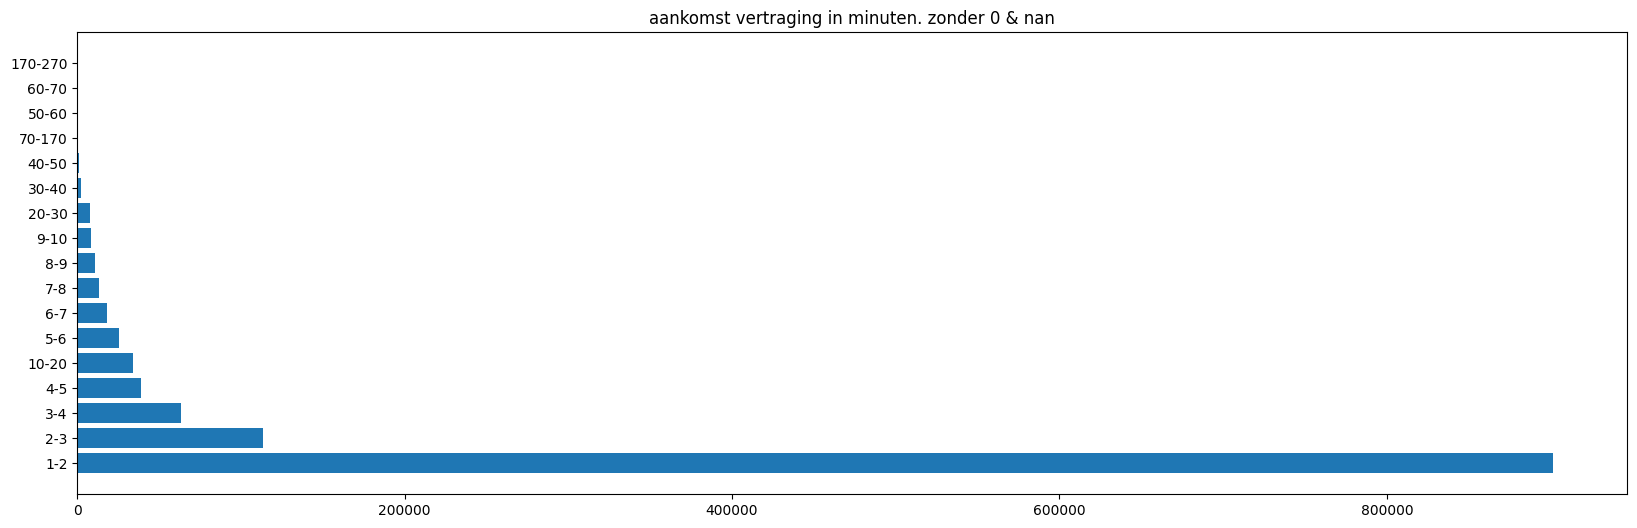

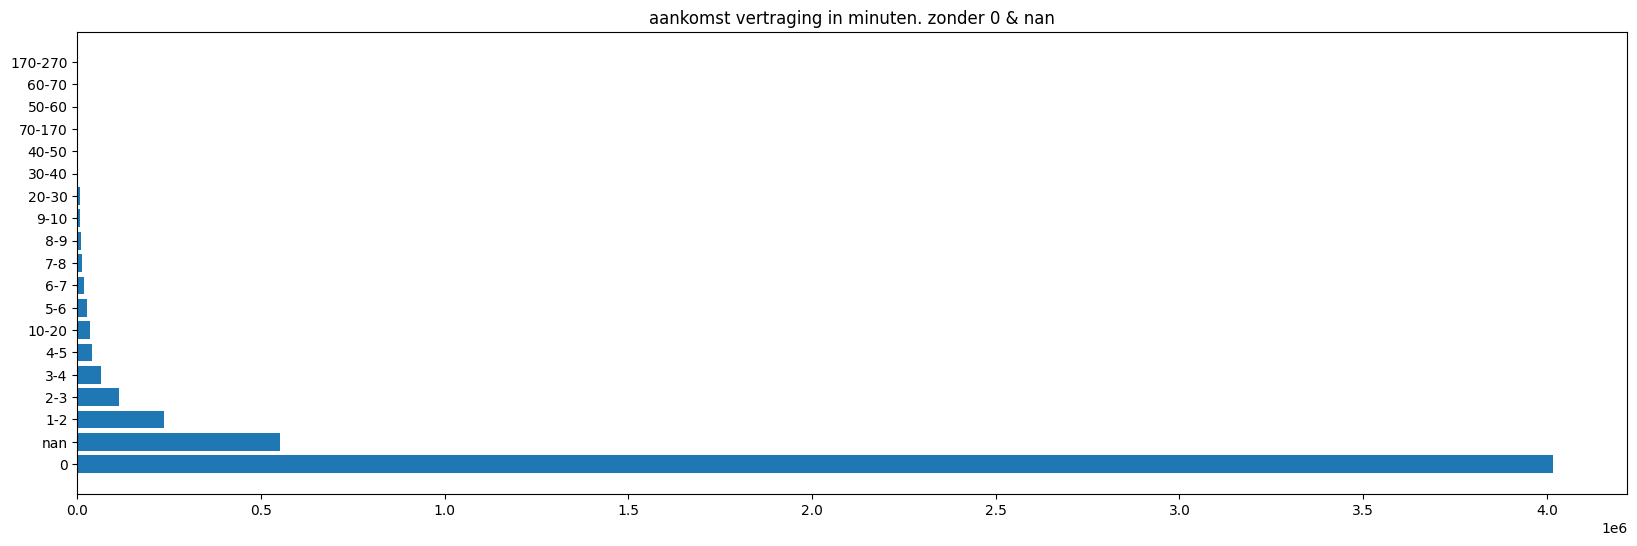

In [10]:
bins =  list(range(1, 10, 1)) + list(range(10, 70, 10)) + list(range(70, int(Train_trafic_2023['Stop:Departure delay'].max()) +100, 100))

labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

counts = pd.cut(Train_trafic_2023['Stop:Departure delay'], bins=bins, labels=labels, include_lowest=True).dropna().astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

labels = ['0'] + labels

bins = [0] + bins 

counts = pd.cut(Train_trafic_2023['Stop:Departure delay'], bins=bins, labels=labels, include_lowest=True).astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

Uit de grafieken hierboven blijkt dat de meeste treinen op tijd vertrekken van hun locatie. Houd er rekening mee dat zowel '0' als 'nan' aangeven dat er geen vertraging is gemeld.

Als ik de 'nan' en '0' weghaal, blijkt dat de vertraging voornamelijk binnen de 10 minuten ligt.

Maar dit hierboven betreft alleen de vertrekvertraging. Hieronder heb ik de aankomstvertraging op dezelfde manier geanalyseerd.

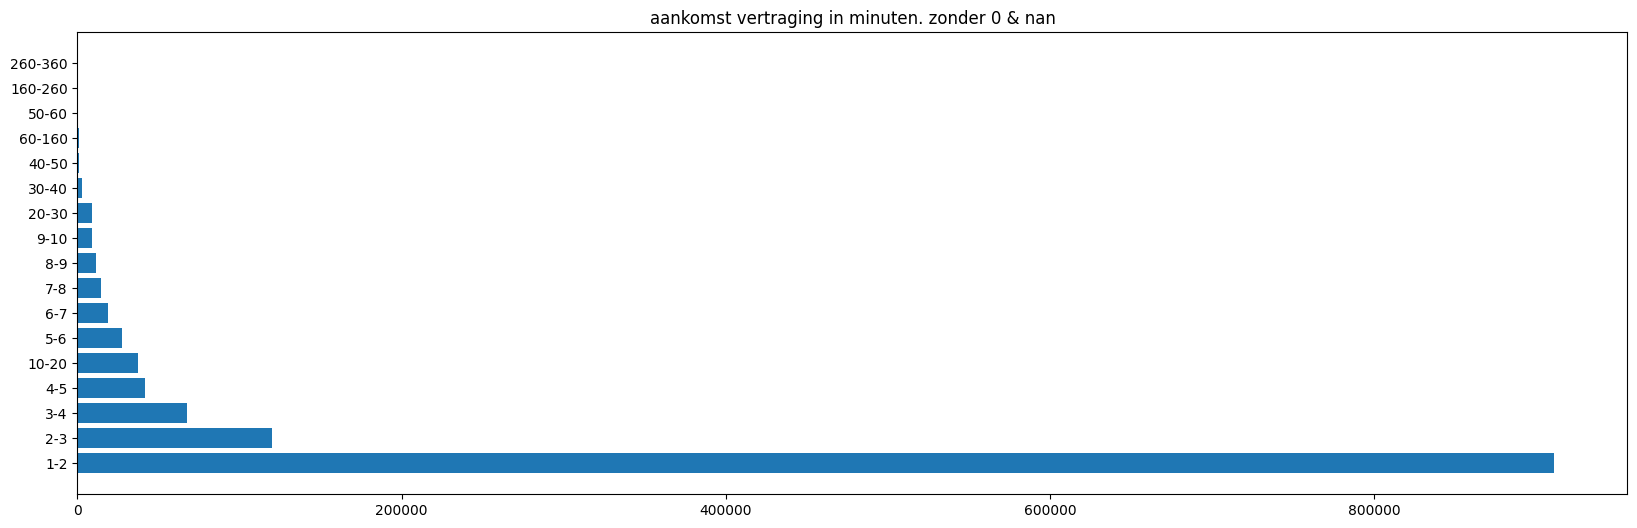

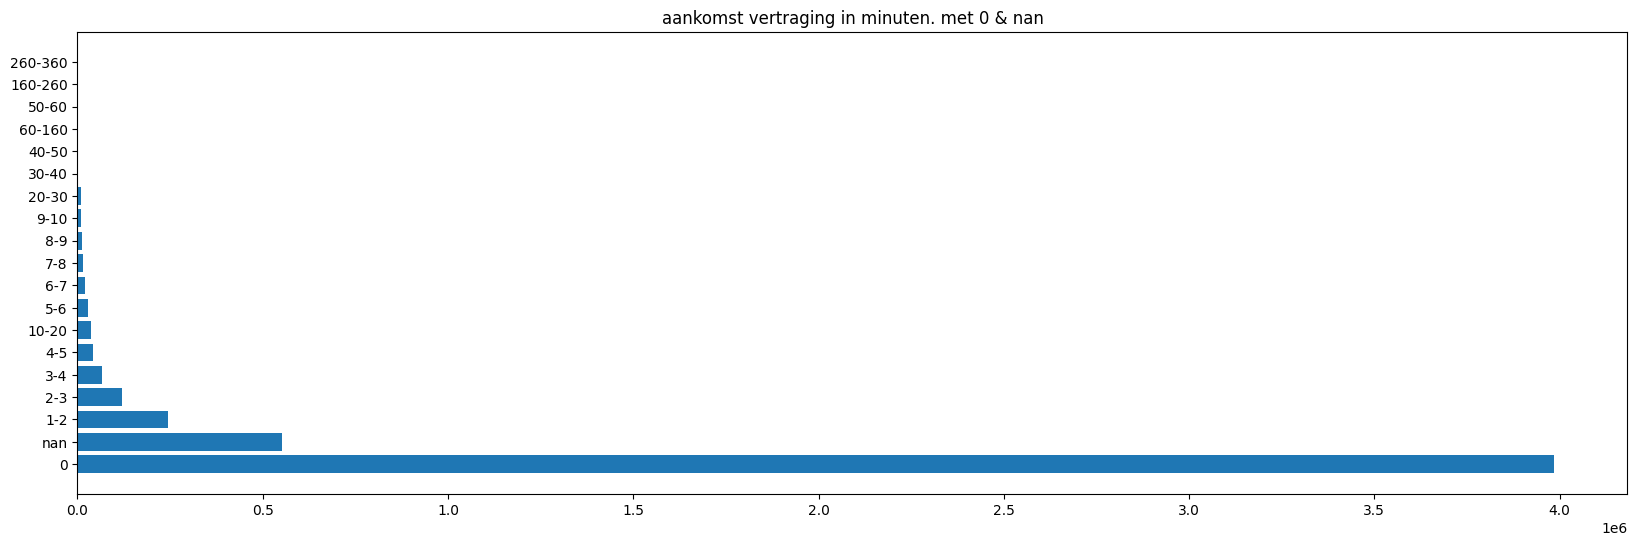

In [11]:
bins = list(range(1, 10, 1)) + list(range(10, 60, 10)) + list(range(60, int(Train_trafic_2023['Stop:Arrival delay'].max()) +100, 100))

labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

counts = pd.cut(Train_trafic_2023['Stop:Arrival delay'], bins=bins, labels=labels, include_lowest=True).dropna().astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

labels = ['0'] + labels 

bins = [0] + bins

counts = pd.cut(Train_trafic_2023['Stop:Arrival delay'], bins=bins, labels=labels, include_lowest=True).astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. met 0 & nan')
plt.show()

Als ik naar de vier grafieken kijk, lijken ze goed overeen te komen. Dit betekent dat als een trein meestal te laat aankomt, hij waarschijnlijk ook te laat zal vertrekken.

Met de tabel hieronder ga ik kijken of er op een bepaalde lijn meer vertraging is dan op een andere. Hierbij moet ik wel oppassen en controleren dat ik niet te vaak dezelfde lijn meeneem. 
Aangezien er is aangegeven dat een RDT-ID meerdere keren kan voorkomen op verschillende dagen, moet ik eerst alles goed bij elkaar zetten. 
Ik neem het gemiddelde omdat ik de gemiddelde vertraging van de ritten op een dag wil zien.

Service:Date  Stop:Arrival delay
0    2023-01-01            0.680368
1    2023-01-02            0.596654
2    2023-01-03            0.565669
3    2023-01-04            0.781114
4    2023-01-05            0.673781
..          ...                 ...
85   2023-03-27            0.799672
86   2023-03-28            0.964126
87   2023-03-29            0.642580
88   2023-03-30            0.710096
89   2023-03-31            0.702228

[90 rows x 2 columns]

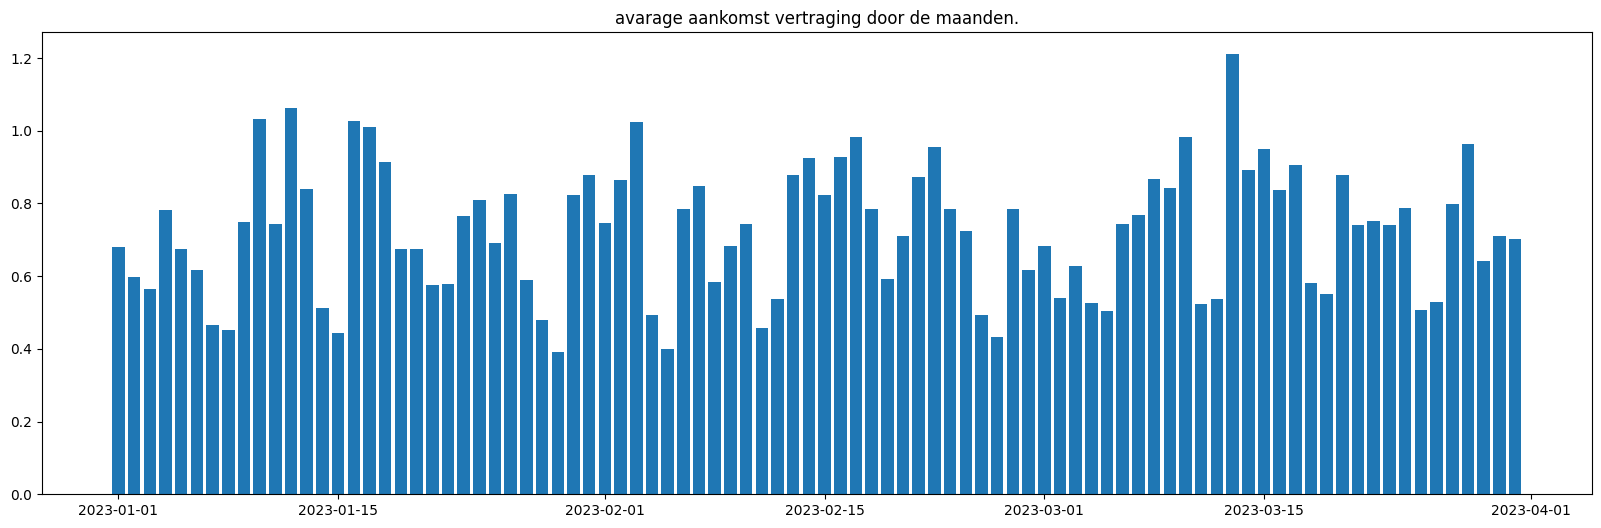

In [12]:
grouped = Train_trafic_2023.groupby(['Service:Date', 'Service:RDT-ID'])['Stop:Arrival delay'].mean()

df_avarage_delay_day = grouped.reset_index(name='Stop:Arrival delay')

grouped = df_avarage_delay_day.groupby(['Service:Date'])['Stop:Arrival delay'].mean()

df_avarage_delay_day = grouped.reset_index(name='Stop:Arrival delay')

display(df_avarage_delay_day)

plt.figure(figsize=(20,6))
plt.bar( df_avarage_delay_day['Service:Date'], df_avarage_delay_day['Stop:Arrival delay'])
plt.title(label='avarage aankomst vertraging door de maanden.')
plt.show()

In de grafiek hierboven is te zien dat de gemiddelde aankomstvertraging varieert gedurende de maanden. \
Dit kan belangrijk zijn voor het testen van de invloed van weersomstandigheden.

### 🌥️ Het weer
Er zijn veel kolommen in de weergegevens en ik ga eerst bepalen wat nodig is en wat niet. Daarvoor ga ik het gemiddelde berekenen en kijken hoe dicht dat bij het antwoord ligt. Als het dichtbij genoeg is, kan ik concluderen dat het gemiddelde representatief is voor heel Nederland. Als dat niet het geval is, moet ik even nadenken over wat ik dan ga doen.

In [13]:
grouped = weather_2023.groupby(by=['start_time']).mean()

db_weather_single_day = grouped.reset_index()

db_weather_single_day = db_weather_single_day.drop(columns=['STN'])

display(db_weather_single_day.head(24))

df_first_date = weather_2023[weather_2023['start_time'] == weather_2023['start_time'].min()]

display(df_first_date[df_first_date['temp'].notna()].sort_values('temp'))


start_time          DD          FH          FF          FX  \
0  2023-01-01 00:00:00+01:00  215.555556  110.666667  110.000000  172.222222   
1  2023-01-01 01:00:00+01:00  215.333333  108.000000  106.444444  167.333333   
2  2023-01-01 02:00:00+01:00  220.222222  107.333333  106.888889  168.000000   
3  2023-01-01 03:00:00+01:00  223.111111  104.000000  103.333333  165.111111   
4  2023-01-01 04:00:00+01:00  224.444444   99.111111   99.111111  158.444444   
5  2023-01-01 05:00:00+01:00  224.666667   95.333333   94.222222  148.444444   
6  2023-01-01 06:00:00+01:00  224.666667   91.333333   89.555556  140.222222   
7  2023-01-01 07:00:00+01:00  222.666667   87.111111   83.777778  134.444444   
8  2023-01-01 08:00:00+01:00  219.111111   81.777778   81.555556  127.555556   
9  2023-01-01 09:00:00+01:00  215.111111   76.666667   76.444444  119.555556   
10 2023-01-01 10:00:00+01:00  216.222222   78.444444   80.222222  120.000000   
11 2023-01-01 11:00:00+01:00  218.444444   78.666667   77.777778  122.888889   
12 2023-01-01 12:00:00+01:00  218.666667   77.555556   74.222222  119.555556   
13 2023-01-01 13:00:00+01:00  212.222222   68.000000   63.777778  107.555556   
14 2023-01-01 14:00:00+01:00  201.555556   59.111111   54.888889   92.666667   
15 2023-01-01 15:00:00+01:00  190.000000   52.000000   49.777778   82.000000   
16 2023-01-01 16:00:00+01:00  182.000000   48.888889   49.777778   76.666667   
17 2023-01-01 17:00:00+01:00  176.000000   49.111111   49.555556   78.222222   
18 2023-01-01 18:00:00+01:00  172.000000   49.333333   49.555556   78.444444   
19 2023-01-01 19:00:00+01:00  173.555556   48.222222   48.222222   78.222222   
20 2023-01-01 20:00:00+01:00  187.333333   41.333333   40.666667   76.222222   
21 2023-01-01 21:00:00+01:00  167.555556   40.444444   40.000000   73.777778   
22 2023-01-01 22:00:00+01:00  172.000000   41.777778   43.555556   70.000000   
23 2023-01-01 23:00:00+01:00  171.777778   43.777778   42.444444   72.444444   

          temp        T10N         TD       SQ         Q  ...     VV     N  \
0   140.617647         NaN  80.382353  0.00000   0.00000  ...  73.28  8.00   
1   138.029412         NaN  80.764706  0.00000   0.00000  ...  74.28  8.00   
2   135.529412         NaN  79.941176  0.00000   0.00000  ...  74.12  8.00   
3   131.323529         NaN  80.911765  0.00000   0.00000  ...  73.20  7.95   
4   125.970588         NaN  79.970588  0.00000   0.00000  ...  73.88  8.00   
5   122.558824  114.294118  76.294118  0.00000   0.00000  ...  73.08  8.00   
6   117.941176         NaN  75.352941  0.00000   0.00000  ...  70.80  8.00   
7   113.647059         NaN  75.970588  0.00000   0.25000  ...  69.88  8.00   
8   112.441176         NaN  78.558824  0.18750   5.62500  ...  69.40  8.00   
9   114.911765         NaN  81.676471  2.62500  25.12500  ...  69.56  8.00   
10  118.764706         NaN  83.588235  3.25000  40.75000  ...  70.64  7.90   
11  120.529412  102.852941  84.882353  1.46875  42.56250  ...  71.48  7.95   
12  121.382353         NaN  84.088235  2.00000  38.59375  ...  71.24  8.00   
13  119.647059         NaN  83.529412  1.06250  23.28125  ...  71.04  8.00   
14  116.352941         NaN  83.352941  1.15625  10.03125  ...  70.52  8.00   
15  113.617647         NaN  83.647059  0.00000   1.18750  ...  69.88  8.00   
16  111.058824         NaN  86.264706  0.00000   0.00000  ...  68.64  8.00   
17  108.735294  100.294118  89.058824  0.00000   0.00000  ...  67.32  8.00   
18  105.764706         NaN  92.147059  0.00000   0.00000  ...  65.08  8.00   
19  104.058824         NaN  93.617647  0.00000   0.00000  ...  62.68  8.00   
20  101.941176         NaN  93.500000  0.00000   0.00000  ...  60.88  8.00   
21  102.264706         NaN  94.764706  0.00000   0.00000  ...  61.36  8.00   
22  105.029412         NaN  95.470588  0.00000   0.00000  ...  60.68  8.00   
23  107.970588   95.647059  96.911765  0.00000   0.00000  ...  59.48  8.00   

            U         WW        IX    M     R    S    O    Y  
0  

STN                start_time     DD     FH     FF     FX   temp  T10N  \
17280  251 2023-01-01 00:00:00+01:00  220.0  140.0  130.0  190.0  108.0   NaN   
6480   235 2023-01-01 00:00:00+01:00  220.0  120.0  120.0  180.0  112.0   NaN   
10800  242 2023-01-01 00:00:00+01:00  220.0  160.0  150.0  210.0  114.0   NaN   
25920  267 2023-01-01 00:00:00+01:00  220.0  130.0  130.0  200.0  121.0   NaN   
19440  257 2023-01-01 00:00:00+01:00    NaN    NaN    NaN    NaN  123.0   NaN   
49680  286 2023-01-01 00:00:00+01:00  210.0  110.0  100.0  170.0  128.0   NaN   
36720  277 2023-01-01 00:00:00+01:00  220.0  120.0  130.0  200.0  130.0   NaN   
32400  273 2023-01-01 00:00:00+01:00  220.0   80.0   70.0  130.0  131.0   NaN   
56160  310 2023-01-01 00:00:00+01:00  200.0  140.0  140.0  180.0  131.0   NaN   
30240  270 2023-01-01 00:00:00+01:00  230.0  140.0  140.0  230.0  132.0   NaN   
43200  280 2023-01-01 00:00:00+01:00  210.0  110.0  100.0  190.0  133.0   NaN   
73440  330 2023-01-01 00:00:00+01:00  210.0  130.0  120.0  210.0  135.0   NaN   
15120  249 2023-01-01 00:00:00+01:00  230.0  140.0  130.0  230.0  136.0   NaN   
8640   240 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  150.0  138.0   NaN   
41040  279 2023-01-01 00:00:00+01:00  220.0   90.0   90.0  150.0  139.0   NaN   
28080  269 2023-01-01 00:00:00+01:00  220.0  100.0  110.0  170.0  141.0   NaN   
2160   215 2023-01-01 00:00:00+01:00  220.0  110.0  130.0  200.0  142.0   NaN   
79920  344 2023-01-01 00:00:00+01:00  210.0  100.0  110.0  180.0  143.0   NaN   
66960  319 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  180.0  145.0   NaN   
69120  323 2023-01-01 00:00:00+01:00  210.0   90.0   90.0  160.0  145.0   NaN   
95040  380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
82080  348 2023-01-01 00:00:00+01:00  220.0  120.0  130.0  180.0  147.0   NaN   
75600  340 2023-01-01 00:00:00+01:00  220.0   70.0   80.0  140.0  148.0   NaN   
38880  278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   
86400  356 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  170.0  151.0   NaN   
51840  290 2023-01-01 00:00:00+01:00  210.0   80.0   70.0  150.0  152.0   NaN   
34560  275 2023-01-01 00:00:00+01:00  220.0  100.0   90.0  150.0  153.0   NaN   
45360  283 2023-01-01 00:00:00+01:00  210.0   70.0   70.0  130.0  154.0   NaN   
84240  350 2023-01-01 00:00:00+01:00  210.0   90.0   90.0  150.0  154.0   NaN   
23760  260 2023-01-01 00:00:00+01:00  220.0   80.0  100.0  160.0  155.0   NaN   
92880  377 2023-01-01 00:00:00+01:00  210.0   90.0   80.0  160.0  155.0   NaN   
90720  375 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  160.0  162.0   NaN   
88560  370 2023-01-01 00:00:00+01:00  220.0  110.0  120.0  190.0  163.0   NaN   
97200  391 2023-01-01 00:00:00+01:00  220.0   50.0   50.0  120.0  163.0   NaN   

         TD   SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
17280  88.0  0.0  ...  58.0  NaN  87.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
6480   95.0  0.0  ...  56.0  8.0  89.0  52.0   7  0.0  1.0  0.0  0.0  0.0  
10800  91.0  NaN  ...  57.0  8.0  86.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
25920  89.0  0.0  ...  64.0  8.0  81.0  57.0   7  0.0  1.0  0.0  0.0  0.0  
19440  83.0  0.0  ...   NaN  NaN  76.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
49680  98.0  0.0  ...   NaN  NaN  82.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
36720  92.0  0.0  ...   NaN  NaN  78.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
32400  93.0  0.0  ...  64.0  NaN  77.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
56160  79.0  0.0  ...  75.0  8.0  70.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
30240  94.0  0.0  ...  74.0  8.0  78.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
43200  94.0  0.0  ...  71.0  8.0  77.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
73440  78.0  0.0  ...   NaN  NaN  68.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
15120  98.0  0.0  ...  63.0  NaN  77.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
8640   92.0  0.0  ...  69.0  8.0  73.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
41040  92.0  0.0  ...  75.0  8.

Het lijkt erop dat er met de temperatuur een verschil van ongeveer 4 graden is tussen de hoogste en laagste temperatuur. Hoewel een verschil van 4 graden niet veel lijkt, kan het ervoor zorgen dat mijn data niet meer klopt. Het lijkt er dus op dat ik toch het verschil tussen de stations moet vinden en het dichtstbijzijnde weerstation moet bepalen. Daarbij moet ik ook rekening houden met het tijdstip van de meting.


### 🏟️ Treinstations 

Allereerst moet ik bepalen welke treinstations ik nodig heb voor mijn datasets. Dat is wat ik hieronder doe. 
Ik neem de stationscodes van het treinverkeer en de codes van de treinstations in de locatiedataset en kijk welke er overeenkomen.

In [14]:
train_station_locations = train_station_locations[train_station_locations['code'].isin(Train_trafic_2023['Stop:Station code'])]

display(train_station_locations)

id  code      uic  name_short       name_medium              name_long  \
0    266    HT  8400319   Den Bosch  's-Hertogenbosch       's-Hertogenbosch   
1    269   HTO  8400320  Dn Bosch O  's-Hertogenb. O.  's-Hertogenbosch Oost   
2    227   HDE  8400388    't Harde          't Harde               't Harde   
3      8  AHBF  8015345      Aachen        Aachen Hbf             Aachen Hbf   
4    818    AW  8015199    Aachen W       Aachen West            Aachen West   
..   ...   ...      ...         ...               ...                    ...   
585  677   ZUE  8503000   Zürich HB         Zürich HB              Zürich HB   
586  534    ZP  8400744     Zutphen           Zutphen                Zutphen   
587  541   ZWD  8400752  Zwijndrcht       Zwijndrecht            Zwijndrecht   
589  532    ZL  8400747      Zwolle            Zwolle                 Zwolle   
590  815  ZLSH  8400746  Stadshagen        Stadshagen      Zwolle Stadshagen   

                     slug country                       type    geo_lat  \
0         s-hertogenbosch      NL  knooppuntIntercitystation  51.690480   
1    s-hertogenbosch-oost      NL           stoptreinstation  51.700554   
2                 t-harde      NL           stoptreinstation  52.409168   
3              aachen-hbf       D  knooppuntIntercitystation  50.767800   
4             aachen-west       D           stoptreinstation  50.780360   
..                    ...     ...                        ...        ...   
585             zurich-hb      CH           intercitystation  47.378190   
586               zutphen      NL  knooppuntIntercitystation  52.145279   
587           zwijndrecht      NL           stoptreinstation  51.814999   
589                zwolle      NL  knooppuntIntercitystation  52.504723   
590     zwolle-stadshagen      NL           stoptreinstation  52.527640   

      geo_lng  
0    5.293620  
1    5.318333  
2    5.893611  
3    6.091499  
4    6.070715  
..        ...  
585  8.539200  
586  6.194167  
587  4.641667  
589  6.091944  
590  6.051460  

[546 rows x 11 columns]

Met deze informatie kan ik mijn treinstations coördinaten geven, zodat ik het dichtstbijzijnde weerstation kan gebruiken.

Maar om dat te testen, voer ik hier eerst een test uit gebaseerd op één meetmoment.

Hier gebruik ik de BallTree-functie van de 'neighbors'-functies van sklearn. Hiermee probeer ik de temperaturen van de stations te ontdekken.

De 'haversine'-metric is een goede metric omdat het de afstand tussen twee locaties kan berekenen.

Ik moet alleen voor de 'haversine'-metric de invoerinformatie omzetten naar de radiaalvorm, gelukkig heeft numpy daar een goede functie voor.

Uiteindelijk doe ik dit om een zo dicht mogelijk weerstation te krijgen. Dit heb ik nodig om te bepalen of de vertragingen in het treinverkeer een verband hebben met het weer.


In [15]:
from sklearn.neighbors import BallTree

df_mergid_first_date_stations = df_first_date.merge(weather_station_location, on='STN', how='inner')

df_mergid_first_date_stations[['LAT(north)_radians', 'LON(east)_radians']] = np.radians(df_mergid_first_date_stations[['LAT(north)', 'LON(east)']])
train_station_locations[['geo_lat_radians', 'geo_lng_radians']] = np.radians(train_station_locations[['geo_lat', 'geo_lng']])

tree = BallTree(df_mergid_first_date_stations[['LAT(north)_radians', 'LON(east)_radians']].dropna().values, metric='haversine')

indices = tree.query(train_station_locations[['geo_lat_radians', 'geo_lng_radians']].dropna().values, return_distance=False, k=1)

nearest_neighbors_weather_station_location = df_mergid_first_date_stations.iloc[indices.flatten()]

train_station_locations.reset_index(drop=True, inplace=True)
nearest_neighbors_weather_station_location.reset_index(drop=True, inplace=True)

combined_df = pd.concat([nearest_neighbors_weather_station_location, train_station_locations], axis=1)

display(combined_df.drop(columns=['geo_lat_radians', 'geo_lng_radians', 'LAT(north)_radians', 'LON(east)_radians', 'name_short', 'name_medium', 'name_long', 'id', 'code', 'uic']))


STN                start_time     DD     FH     FF     FX   temp  T10N  \
0    356 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  170.0  151.0   NaN   
1    356 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  170.0  151.0   NaN   
2    278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   
3    380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
4    380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
..   ...                       ...    ...    ...    ...    ...    ...   ...   
541  380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
542  275 2023-01-01 00:00:00+01:00  220.0  100.0   90.0  150.0  153.0   NaN   
543  344 2023-01-01 00:00:00+01:00  210.0  100.0  110.0  180.0  143.0   NaN   
544  278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   
545  278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   

       TD   SQ  ...    Y  LON(east)  LAT(north)  ALT(m)        NAME  \
0    80.0  0.0  ...  NaN      5.146      51.859     0.7   Herwijnen   
1    80.0  0.0  ...  NaN      5.146      51.859     0.7   Herwijnen   
2    83.0  0.0  ...  NaN      6.259      52.435     3.6       Heino   
3    42.0  0.0  ...  0.0      5.762      50.906   114.3  Maastricht   
4    42.0  0.0  ...  0.0      5.762      50.906   114.3  Maastricht   
..    ...  ...  ...  ...        ...         ...     ...         ...   
541  42.0  0.0  ...  0.0      5.762      50.906   114.3  Maastricht   
542  76.0  0.0  ...  0.0      5.873      52.056    48.2      Deelen   
543  88.0  0.0  ...  0.0      4.447      51.962    -4.3   Rotterdam   
544  83.0  0.0  ...  NaN      6.259      52.435     3.6       Heino   
545  83.0  0.0  ...  NaN      6.259      52.435     3.6       Heino   

                     slug  country                       type    geo_lat  \
0         s-hertogenbosch       NL  knooppuntIntercitystation  51.690480   
1    s-hertogenbosch-oost       NL           stoptreinstation  51.700554   
2                 t-harde       NL           stoptreinstation  52.409168   
3              aachen-hbf        D  knooppuntIntercitystation  50.767800   
4             aachen-west        D           stoptreinstation  50.780360   
..                    ...      ...                        ...        ...   
541             zurich-hb       CH           intercitystation  47.378190   
542               zutphen       NL  knooppuntIntercitystation  52.145279   
543           zwijndrecht       NL           stoptreinstation  51.814999   
544                zwolle       NL  knooppuntIntercitystation  52.504723   
545     zwolle-stadshagen       NL           stoptreinstation  52.527640   

      geo_lng  
0    5.293620  
1    5.318333  
2    5.893611  
3    6.091499  
4    6.070715  
..        ...  
541  8.539200  
542  6.194167  
543  4.641667  
544  6.091944  
545  6.051460  

[546 rows x 33 columns]

Uit de test hierboven kan ik concluderen dat ik met de weerstations en treinstationlocaties redelijk goed het dichtstbijzijnde weerstation van een treinstation kan vinden.

# 🎛️ Correlatie bekijken

Hier ga ik de correlatieplots van de datasets weergeven.

### 🚄 Treinverkeer 
Dit is de correlatieplot van het treinverkeer:

<Axes: >

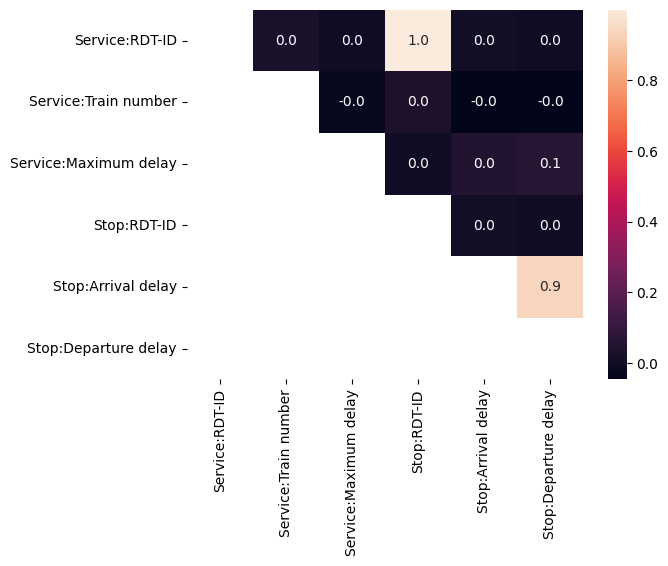

In [16]:
corr = Train_trafic_2023.select_dtypes(include=['int32', 'int64', 'float64']).corr()

mask = np.tril(corr)

sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f")

Het lijkt erop dat als ik de correlatieplot van de afzonderlijke treininformatie maak, er een lage correlatie tussen de gegevens is. 
Hieronder ga ik een pairplot maken om te zien of ik er meer uit kan halen.

<Figure size 2000x2000 with 0 Axes>

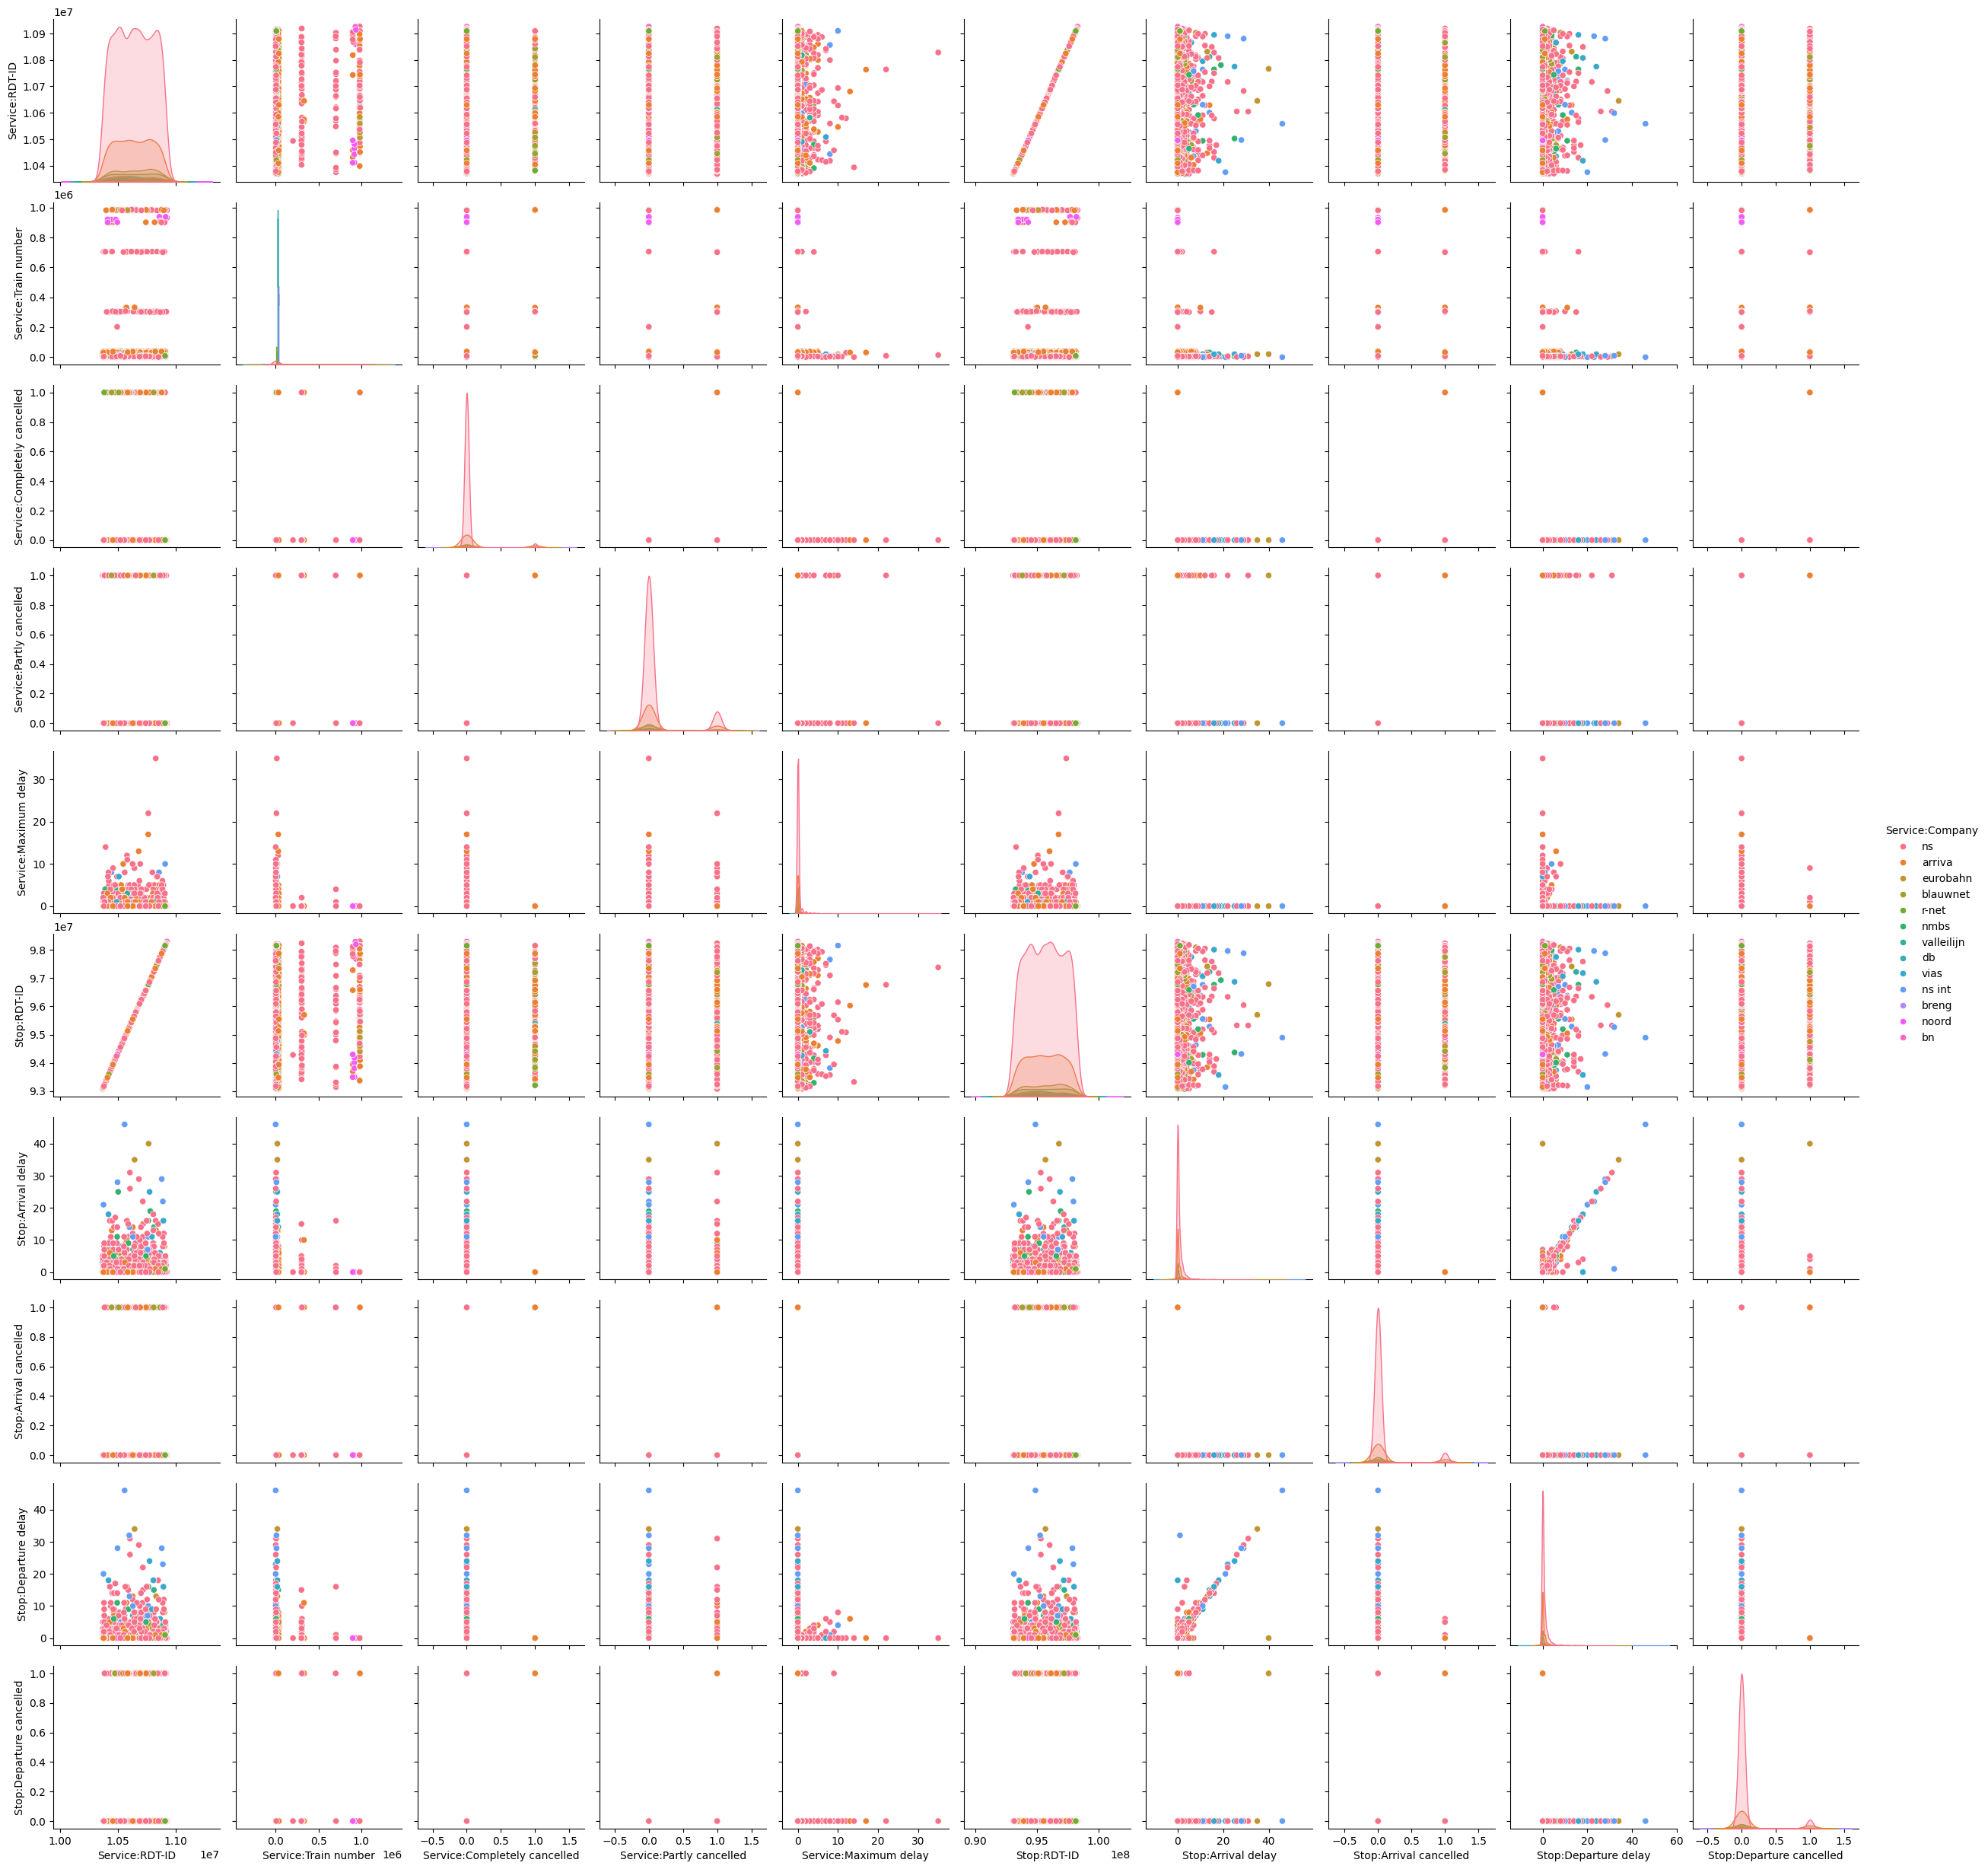

In [17]:
plt.figure(figsize=(20,20))
sns.pairplot(Train_trafic_2023.sample(frac=0.001), hue='Service:Company')

Hoewel ik de hoeveelheid data heb moeten verminderen, heb ik toch een goed gevoel over de inhoud van mijn dataset.

### 🌥️ het weer

<Axes: >

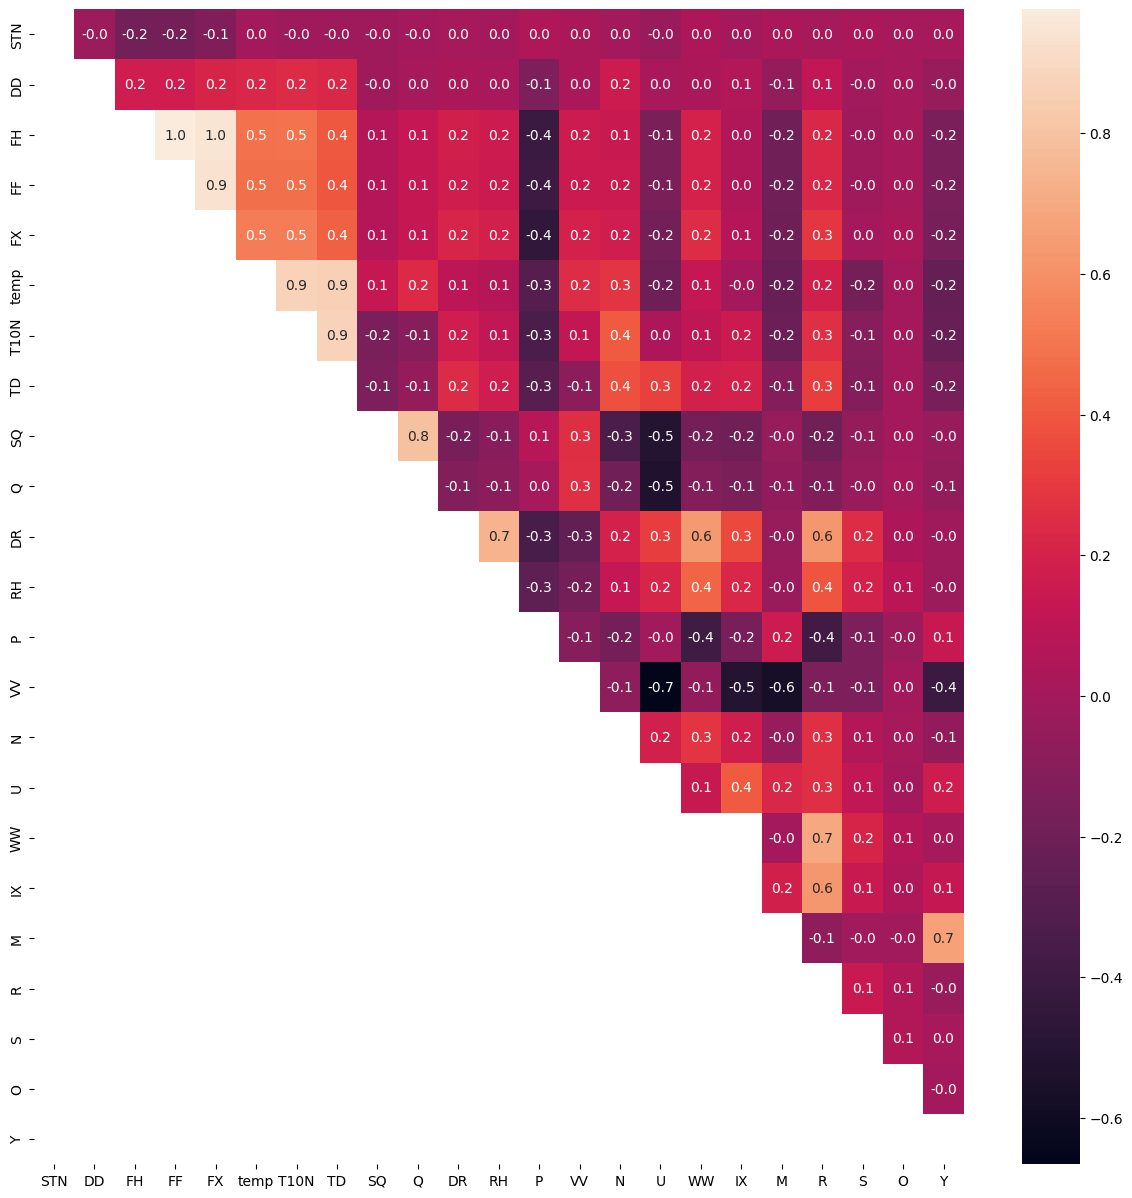

In [18]:
plt.subplots(figsize=(15, 15))

corr = weather_2023.select_dtypes(include=['int32', 'int64', 'float64']).corr()
mask = np.tril(corr);
sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f",)

Het lijkt erop dat verschillende weerelementen een sterke relatie met elkaar hebben. Het gaat niet alleen om de hoeveelheid, maar ook om de elementen die naar verwachting met elkaar in verband staan. Bijvoorbeeld, de temperatuur en de minimale temperatuur elke 6 uur vertonen een sterke correlatie.

STN                start_time     DD    FH    FF     FX   temp  T10N  \
63002  315 2023-01-16 02:00:00+01:00  150.0  80.0  80.0  100.0    NaN   NaN   
85794  350 2023-03-06 18:00:00+01:00  210.0  50.0  50.0   90.0   39.0   NaN   
9791   240 2023-02-17 23:00:00+01:00  230.0  40.0  50.0   70.0   94.0  89.0   
9734   240 2023-02-15 14:00:00+01:00  200.0  40.0  40.0   60.0   99.0   NaN   
94044  377 2023-02-18 12:00:00+01:00  250.0  60.0  70.0  140.0  104.0   NaN   
...    ...                       ...    ...   ...   ...    ...    ...   ...   
24577  260 2023-02-04 01:00:00+01:00  300.0  20.0  20.0   40.0   67.0   NaN   
87145  356 2023-02-01 01:00:00+01:00  240.0  50.0  50.0   70.0   39.0   NaN   
63645  315 2023-02-11 21:00:00+01:00  310.0  20.0  10.0   30.0    NaN   NaN   
21572  257 2023-03-30 20:00:00+02:00    NaN   NaN   NaN    NaN   95.0   NaN   
82865  348 2023-02-02 17:00:00+01:00  230.0  50.0  50.0   80.0   81.0  76.0   

         TD   SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
63002   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
85794  19.0  0.0  ...  57.0  8.0  87.0  58.0   7  0.0  1.0  0.0  0.0  0.0  
9791   88.0  0.0  ...  58.0  8.0  95.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
9734   51.0  8.0  ...  61.0  8.0  71.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
94044  95.0  0.0  ...  61.0  8.0  93.0  51.0   7  0.0  1.0  0.0  0.0  0.0  
...     ...  ...  ...   ...  ...   ...   ...  ..  ...  ...  ...  ...  ...  
24577  58.0  0.0  ...  60.0  8.0  94.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
87145  17.0  0.0  ...   NaN  NaN  85.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
63645   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
21572  84.0  0.0  ...   NaN  NaN  92.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
82865  70.0  0.0  ...  65.0  NaN  93.0   0.0   7  0.0  0.0  0.0  0.0  0.0  

[99 rows x 24 columns]

<Figure size 2000x2000 with 0 Axes>

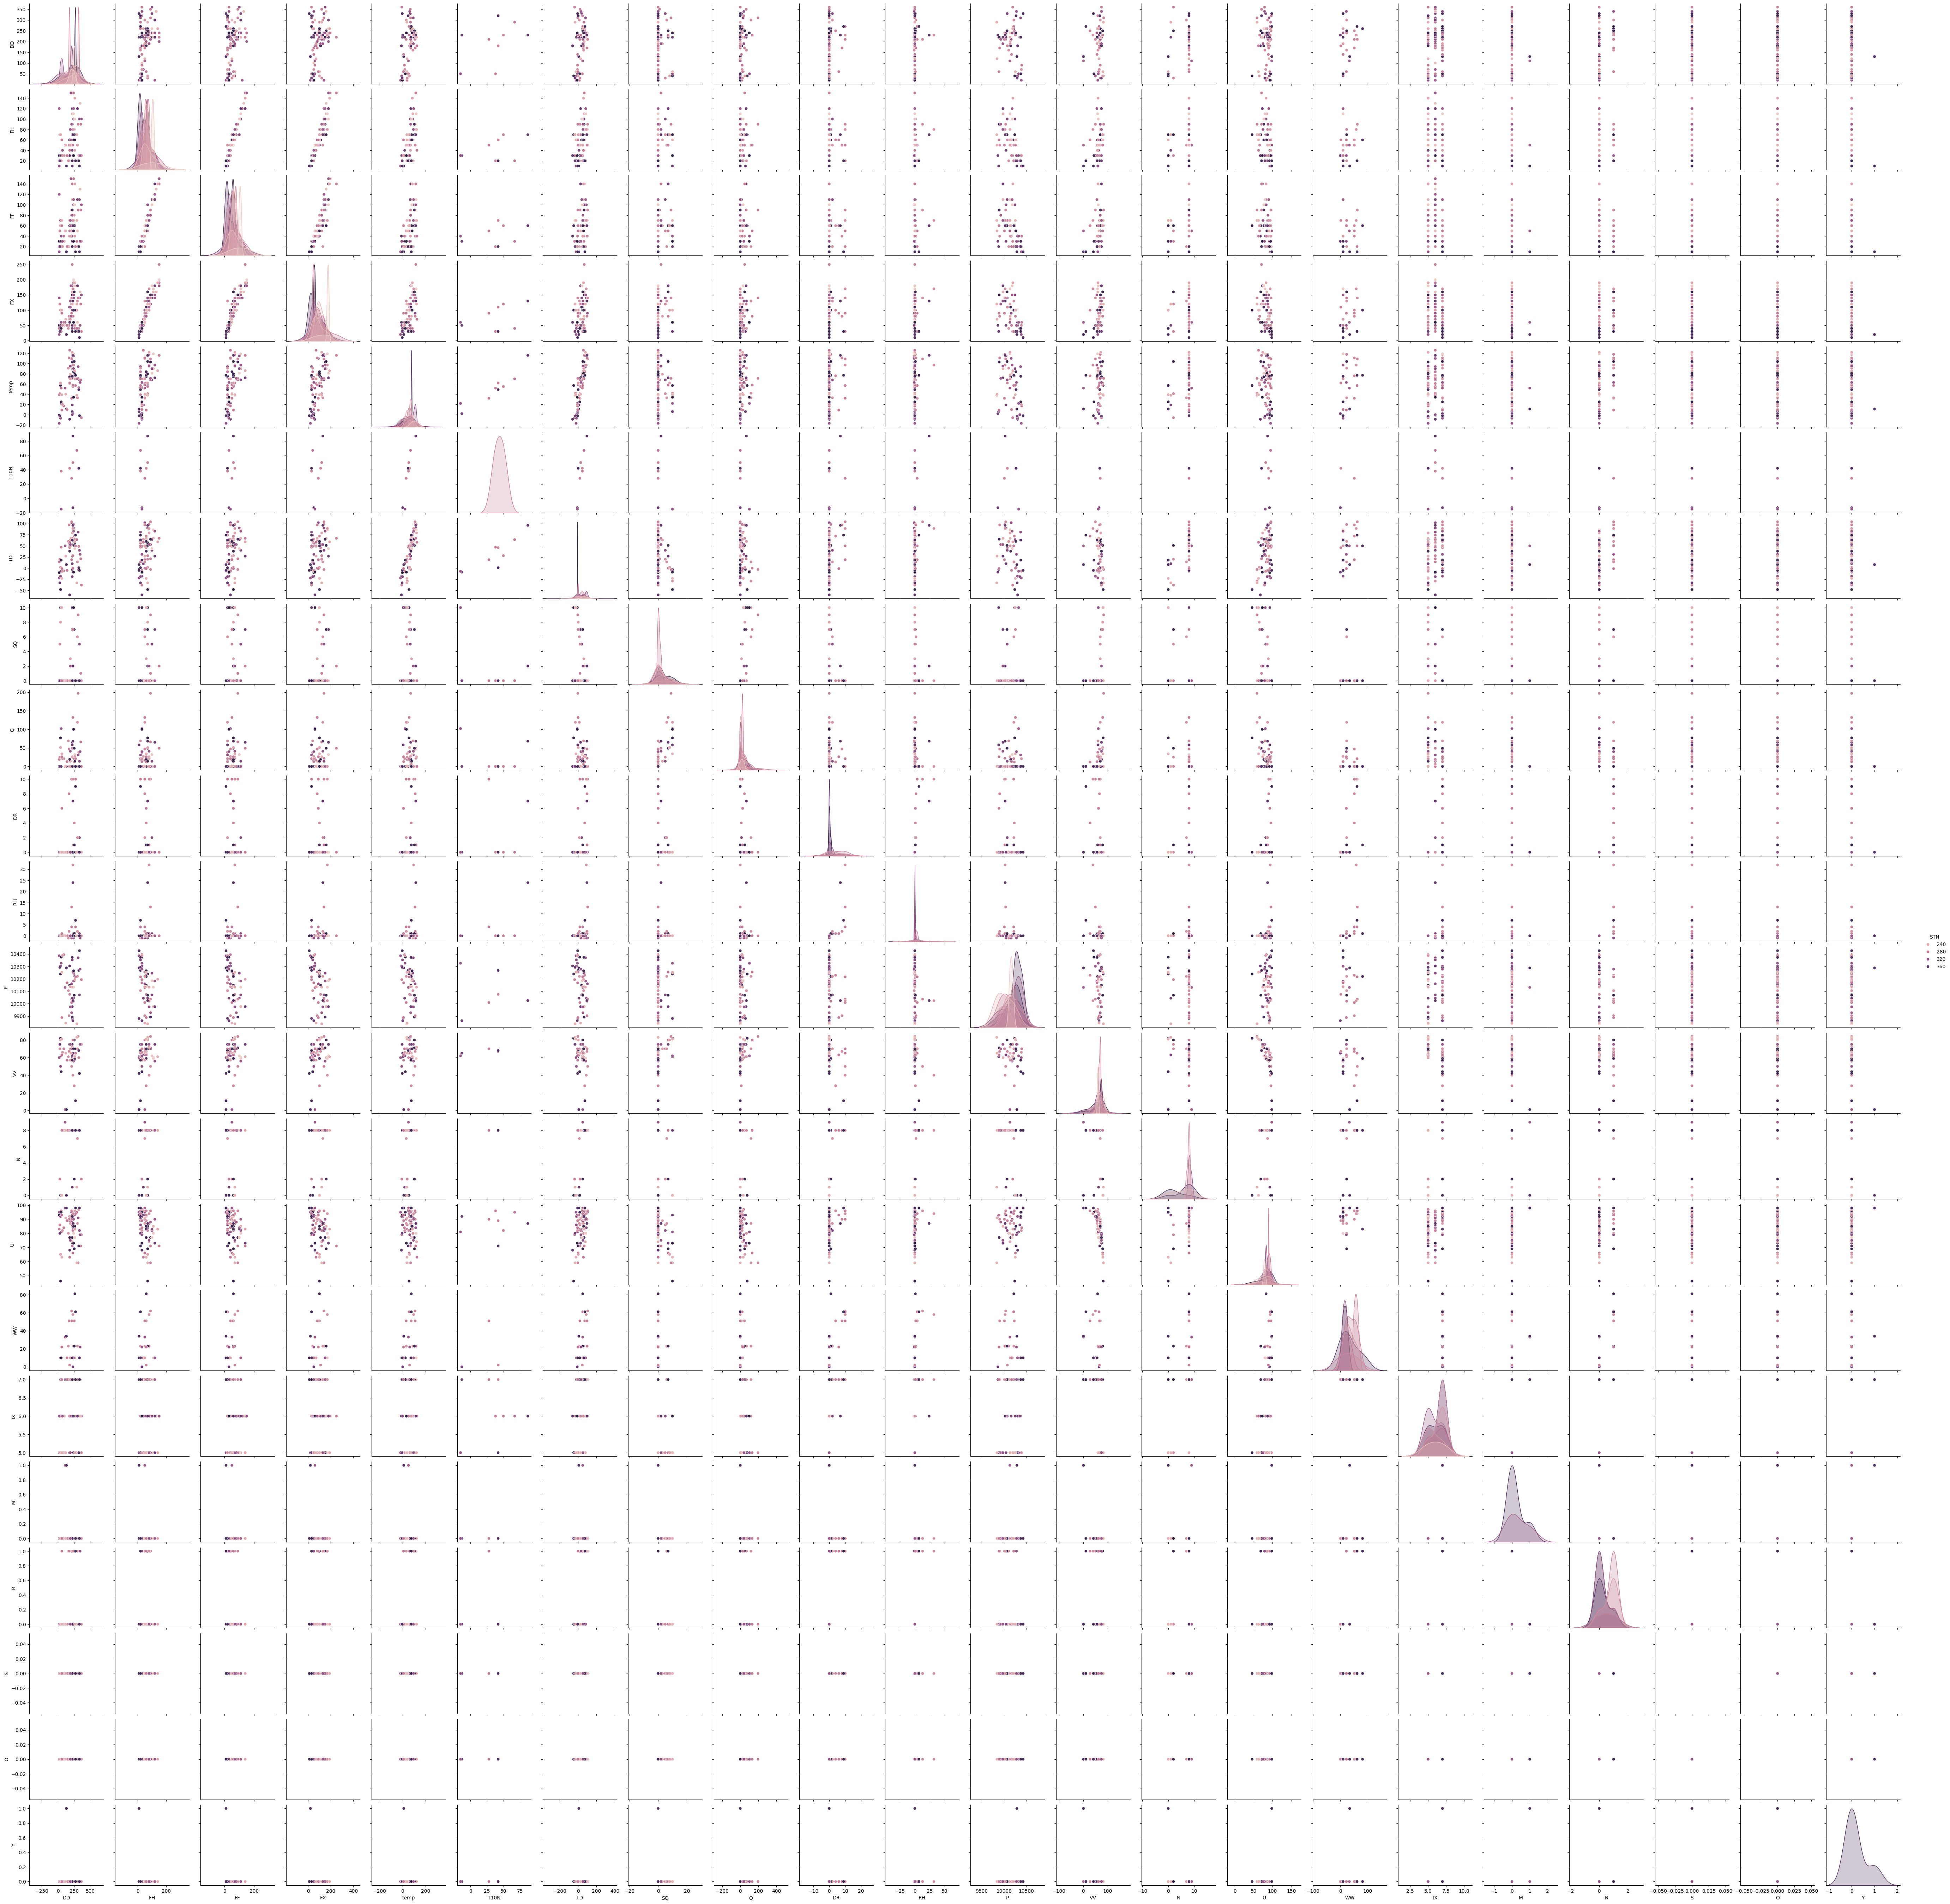

In [19]:
plt.figure(figsize=(20,20))
display(weather_2023.sample(frac=0.001))
sns.pairplot(weather_2023.sample(frac=0.001), hue='STN')

### 🏟️ trein station 

<Axes: >

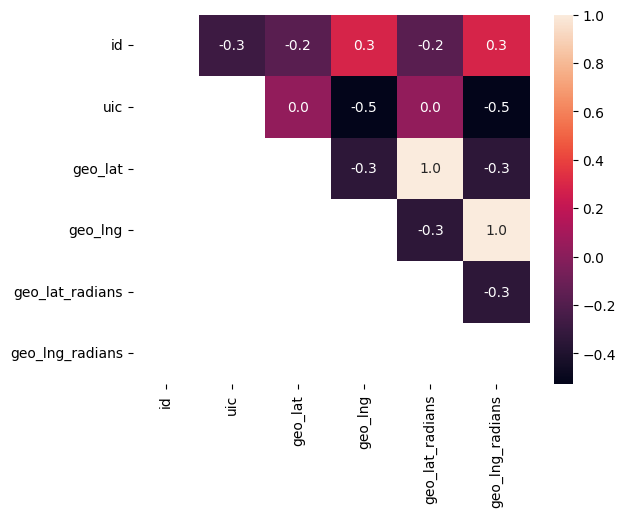

In [20]:
corr = train_station_locations.select_dtypes(include=['int32', 'int64', 'float64']).corr()
mask = np.tril(corr)
sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f")

Dit was meer om te kijken of ik iets terug zou krijgen, maar het geeft een goed voorbeeld van de gegevens.

# 🛠️ Preprocessing

Ik ga onderzoeken of ik de datasets kan samenvoegen, zodat ik één volledige dataset krijg met mijn informatie. \
Uiteraard moet de data op de juiste plek staan.

### 🚄&🏟️ Treinverkeer samenvoegen met treinstation
Hieronder ga ik al het treinverkeer voorzien van hun treinstationgegevens, zodat ik het later kan samenvoegen met het juiste weerstation. \
Hiervoor ga ik een nieuwe variabele aanmaken, zodat ik het meerdere keren kan uitvoeren zonder dat het de data hierboven verstoort. \
De samenvoeging zal worden gedaan door de twee datasets te joinen met de merge-functie van Panda's. \
De join zal alle gegevens van beide tabellen bevatten. Ik gebruik in de merge de stationscode die in beide tabellen voorkomt. Hoewel ze anders worden genoemd, zijn het allebei de stationscodes. \
Dit zou niet het moeilijkste moeten zijn, aangezien de datasets van dezelfde provider komen.

In [21]:
# train_station_locations , Train_trafic_2023
display(
   train_station_locations[train_station_locations['name_short']== "Nw A'dam"] 
)
train_trafic_with_locations = Train_trafic_2023.merge(right=train_station_locations, how='outer', left_on='Stop:Station code', right_on='code')
display(train_trafic_with_locations)


id code      uic name_short    name_medium        name_long  \
351  349  NaN  8400454   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   

                slug country              type    geo_lat   geo_lng  \
351  nieuw-amsterdam      NL  sneltreinstation  52.718613  6.848611   

     geo_lat_radians  geo_lng_radians  
351         0.920113         0.119531

Service:RDT-ID Service:Date Service:Type Service:Company  \
0              10368001   2023-01-01     sprinter              ns   
1              10368079   2023-01-01     sprinter              ns   
2              10368089   2023-01-01     sprinter              ns   
3              10368125   2023-01-01     sprinter              ns   
4              10368142   2023-01-01     sprinter              ns   
...                 ...          ...          ...             ...   
5142245        10915642   2023-03-31    stoptrein        blauwnet   
5142246        10915677   2023-03-31    sneltrein        blauwnet   
5142247        10915796   2023-03-31    stoptrein        blauwnet   
5142248        10915874   2023-03-31    stoptrein        blauwnet   
5142249        10915882   2023-03-31    stoptrein        blauwnet   

         Service:Train number  Service:Completely cancelled  \
0                        4026                         False   
1                        4037                         False   
2                        4035                         False   
3                        4030                         False   
4                        4028                         False   
...                       ...                           ...   
5142245                  8092                         False   
5142246                  3879                         False   
5142247                  8081                         False   
5142248                  8096                         False   
5142249                  8083                         False   

         Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                           False                      0     93070750   
1                           False                      0     93071464   
2                           False                      0     93071556   
3                           False                      0     93071943   
4                           False                      0     93072094   
...                           ...                    ...          ...   
5142245                     False                      0     98208124   
5142246                     False                      0     98208425   
5142247                     False                      0     98209348   
5142248                     False                      0     98209890   
5142249                     False                      0     98209958   

        Stop:Station code  ... name_short    name_medium        name_long  \
0                      AC  ...    Abcoude        Abcoude          Abcoude   
1                      AC  ...    Abcoude        Abcoude          Abcoude   
2                      AC  ...    Abcoude        Abcoude          Abcoude   
3                      AC  ...    Abcoude        Abcoude          Abcoude   
4                      AC  ...    Abcoude        Abcoude          Abcoude   
...                   ...  ...        ...            ...              ...   
5142245               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142246               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142247               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142248               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142249               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   

                    slug country              type    geo_lat   geo_lng  \
0                abcoude      NL  stoptreinstation  52.278500  4.977000   
1                abcoude      NL  stoptreinstation  52.278500  4.977000   
2                abcoude      NL  stoptreinstation  52.278500  4.977000   
3                abcoude      NL  stoptreinstation  52.278500  4.977000   
4                abcoude      NL  stoptreinstation  52.278500  4.977000   
...                  ...     ...               ...        ...       ...   
5142245  nieuw-amsterdam      NL  sneltreinstation  52.718613  6.848611   
5142246  nieuw-amster

Voor deze verbinding heb ik ontdekt dat het station 'New Amsterdam' een stationscode heeft die 'NaN' is, en niet de variabele NaN. \
Maar na deze ontdekking verliep de verbinding vlekkeloos.


### 🌥️&🚄🏟️ Het weer samenvoegen met het al samengevoegde treinverkeer en stations

Voor deze taak zal ik waarschijnlijk machine learning moeten gebruiken om het juiste weerstation aan een treinstation te koppelen. \
Dit komt omdat een weerstation ook in de loop van de tijd kan veranderen, wat invloed heeft op het weer.

Als eerste stap ga ik kijken welk weerstation het dichtst bij welk treinstation ligt.

In [22]:
from sklearn.neighbors import BallTree
import numpy as np

# weather_station_location, train_trafic_with_locations, weather_2023

# Weather_With_location_time = weather_2023.merge(weather_station_location, on='STN', how='inner')

tree = BallTree(np.radians(weather_station_location[['LAT(north)', 'LON(east)']]), metric='haversine')
distances, indices = tree.query(np.radians(train_trafic_with_locations[['geo_lat', 'geo_lng']].dropna()), dualtree=True)

display(distances)
display(indices)
display(weather_2023)

array([[0.00211167],
       [0.00211167],
       [0.00211167],
       ...,
       [0.00295339],
       [0.00295339],
       [0.00295339]])

array([[ 5],
       [ 5],
       [ 5],
       ...,
       [21],
       [21],
       [21]], dtype=int64)

STN                start_time     DD     FH     FF     FX  temp  T10N  \
0      209 2023-01-01 00:00:00+01:00  220.0  140.0  150.0  170.0   NaN   NaN   
1      209 2023-01-01 01:00:00+01:00  220.0  130.0  130.0  170.0   NaN   NaN   
2      209 2023-01-01 02:00:00+01:00  240.0  140.0  130.0  200.0   NaN   NaN   
3      209 2023-01-01 03:00:00+01:00  220.0  120.0  130.0  170.0   NaN   NaN   
4      209 2023-01-01 04:00:00+01:00  230.0  130.0  140.0  170.0   NaN   NaN   
...    ...                       ...    ...    ...    ...    ...   ...   ...   
99355  391 2023-03-31 19:00:00+02:00  210.0   50.0   40.0  120.0  99.0   NaN   
99356  391 2023-03-31 20:00:00+02:00  220.0   40.0   50.0  100.0  99.0   NaN   
99357  391 2023-03-31 21:00:00+02:00  210.0   40.0   40.0  110.0  97.0   NaN   
99358  391 2023-03-31 22:00:00+02:00  220.0   40.0   40.0   90.0  95.0   NaN   
99359  391 2023-03-31 23:00:00+02:00  220.0   50.0   50.0  110.0  94.0  96.0   

         TD   SQ  ...  VV   N     U  WW  IX   M   R   S   O   Y  
0       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
1       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
2       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
3       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
4       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
...     ...  ...  ...  ..  ..   ...  ..  ..  ..  ..  ..  ..  ..  
99355  88.0  0.0  ... NaN NaN  93.0 NaN   6 NaN NaN NaN NaN NaN  
99356  86.0  0.0  ... NaN NaN  91.0 NaN   6 NaN NaN NaN NaN NaN  
99357  87.0  0.0  ... NaN NaN  93.0 NaN   6 NaN NaN NaN NaN NaN  
99358  88.0  0.0  ... NaN NaN  95.0 NaN   6 NaN NaN NaN NaN NaN  
99359  88.0  0.0  ... NaN NaN  95.0 NaN   6 NaN NaN NaN NaN NaN  

[99360 rows x 24 columns]

Hierboven heb ik ervoor gezorgd dat ik weet welk weerstation het dichtst bij een treinstation staat. \
Deze informatie heb ik hieronder nodig om een dataset te creëren die alle gegevens van het weerstation bij de treingegevens voegt.

Hieronder ga ik de data samenvoegen zodat ik uiteindelijk één dataset heb waar alles in staat dat ik nodig zou moeten hebben. \
Dit doe ik door de dichtstbijzijnde tijd bij zijn dichtstbijzijnde weerstation te zoeken. Ik heb ervoor gekozen om voor het testen minder data te gebruiken, zodat ik sneller feedback krijg van mijn outputs.


In [42]:
combined_data = []

for i, train_station in train_trafic_with_locations.sample(frac=0.05).iterrows():
    if(indices.size > i):
        nearest_weather_station = weather_station_location.iloc[indices[i][0]]
        nearest_weather_station = weather_2023[weather_2023['STN'] == nearest_weather_station.STN]  #pd.merge(weather_station_location[weather_station_location['STN'] == ], weather_2023, on='STN')
        if(nearest_weather_station['start_time'].count() > 0):
            if (pd.notnull(train_station['Stop:Arrival time'])):
                time_diffs = abs(nearest_weather_station['start_time'] - train_station['Stop:Arrival time'])

                nearest_time_index = time_diffs.idxmin()
                nearest_weather_data = nearest_weather_station.loc[nearest_time_index]

                combined_row = pd.concat([train_station, nearest_weather_data])
                combined_data.append(combined_row)

combined_df = pd.DataFrame(combined_data)

combined_df.reset_index(drop=True, inplace=True)

combined_df



display(combined_df)

Service:RDT-ID Service:Date          Service:Type Service:Company  \
0             10794078   2023-03-12              sprinter              ns   
1             10476530   2023-01-20             stoptrein          arriva   
2             10504457   2023-01-24             intercity              ns   
3             10481715   2023-01-20             intercity              ns   
4             10614169   2023-02-11             stoptrein           r-net   
...                ...          ...                   ...             ...   
214485        10481760   2023-01-19  stopbus i.p.v. trein           noord   
214486        10695669   2023-02-24             intercity              ns   
214487        10602805   2023-02-09  stopbus i.p.v. trein        eurobahn   
214488        10661084   2023-02-19              sprinter              ns   
214489        10542710   2023-01-30              sprinter              ns   

        Service:Train number  Service:Completely cancelled  \
0                       5139                         False   
1                      32519                          True   
2                       2968                         False   
3                      11678                         False   
4                       7244                         False   
...                      ...                           ...   
214485                918909                          True   
214486                  3553                         False   
214487                982045                         False   
214488                  9025                         False   
214489                  4369                         False   

        Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                          False                      0     97055924   
1                           True                      0     94125816   
2                          False                      0     94386444   
3                          False                      0     94178056   
4                          False                      0     95414176   
...                          ...                    ...          ...   
214485                      True                      0     94178517   
214486                     False                      0     96169809   
214487                     False                      0     95304943   
214488                     False                      0     95849966   
214489                     False                      0     94738025   

       Stop:Station code  ...    VV    N     U    WW IX    M    R    S    O  \
0                   DTCP  ...  60.0  7.0  87.0   1.0  7  0.0  0.0  0.0  0.0   
1                    SBK  ...  57.0  8.0  91.0  10.0  7  0.0  0.0  0.0  0.0   
2                    EHV  ...  59.0  8.0  80.0  10.0  7  0.0  0.0  0.0  0.0   
3                   ASDZ  ...  58.0  2.0  88.0  10.0  7  0.0  0.0  0.0  0.0   
4                   HBZM  ...  70.0  NaN  81.0   NaN  5  0.0  0.0  0.0  0.0   
...                  ...  ...   ...  ...   ...   ... ..  ...  ...  ...  ...   
214485                LG  ...  58.0  8.0  93.0  24.0  7  0.0  1.0  1.0  0.0   
214486                DN  ...  70.0  3.0  81.0   1.0  7  0.0  0.0  0.0  0.0   
214487              KBRY  ...   NaN  NaN  68.0   NaN  6  NaN  NaN  NaN  NaN   
214488                GW  ...  70.0  7.0  81.0   NaN  5  0.0  0.0  0.0  0.0   
214489               SHL  ...  68.0  2.0  81.0   NaN  5  0.0  0.0  0.0  0.0   

          Y  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
214485  0.0  
214486  0.0  
214487  NaN  
214488  0.0  
214489  0.0  

[214490 rows x 54 columns]

Hieronder ga ik controleren of de data overeenkomt met wat ik verwacht. \
Dit betekent dat de geografische coördinaten en de tijden dicht bij elkaar moeten liggen.

In [43]:
Test_combined_df = combined_df.merge(weather_station_location, on='STN', how='inner')
display(Test_combined_df[['LAT(north)', 'LON(east)','geo_lat', 'geo_lng', 'start_time', 'Stop:Arrival time']])
display(Test_combined_df.info())

LAT(north)  LON(east)    geo_lat   geo_lng                start_time  \
0           51.962      4.447  51.990833  4.364722 2023-03-12 11:00:00+01:00   
1           50.906      5.762  50.943270  5.850529 2023-01-20 06:00:00+01:00   
2           51.451      5.377  51.443333  5.481389 2023-01-24 19:00:00+01:00   
3           52.318      4.790  52.338889  4.872356 2023-01-20 23:00:00+01:00   
4           51.970      4.926  51.829440  4.815560 2023-02-11 14:00:00+01:00   
...            ...        ...        ...       ...                       ...   
214485      50.906      5.762  50.896389  6.019166 2023-01-19 07:00:00+01:00   
214486      51.659      5.707  51.455833  5.788889 2023-02-24 17:00:00+01:00   
214487      51.498      6.197  51.294615  6.241174 2023-02-09 16:00:00+01:00   
214488      53.224      5.752  53.088890  5.822500 2023-02-19 10:00:00+01:00   
214489      52.318      4.790  52.309444  4.761944 2023-01-30 19:00:00+01:00   

                Stop:Arrival time  
0       2023-03-12 10:42:00+01:00  
1       2023-01-20 06:25:00+01:00  
2       2023-01-24 19:02:00+01:00  
3       2023-01-20 22:45:00+01:00  
4       2023-02-11 14:20:00+01:00  
...                           ...  
214485  2023-01-19 07:01:00+01:00  
214486  2023-02-24 16:35:00+01:00  
214487  2023-02-09 15:35:00+01:00  
214488  2023-02-19 09:47:00+01:00  
214489  2023-01-30 18:56:00+01:00  

[214490 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214490 entries, 0 to 214489
Data columns (total 58 columns):
 #   Column                        Non-Null Count   Dtype                           
---  ------                        --------------   -----                           
 0   Service:RDT-ID                214490 non-null  int64                           
 1   Service:Date                  214490 non-null  datetime64[ns]                  
 2   Service:Type                  214490 non-null  object                          
 3   Service:Company               214490 non-null  object                          
 4   Service:Train number          214490 non-null  int64                           
 5   Service:Completely cancelled  214490 non-null  bool                            
 6   Service:Partly cancelled      214490 non-null  bool                            
 7   Service:Maximum delay         214490 non-null  int64                           
 8   Stop:RDT-ID                   2144

None

Uit de gegevens hierboven kan ik afleiden dat het gelukt is om het dichtstbijzijnde weerstation te vinden voor een treinstation, met de tijd als extra parameter. \
Met deze data kan ik eindelijk beginnen met het analyseren van wat een machine learning algoritme denkt over de data. Maar eerst ga ik kijken hoe de correlaties van deze hele dataset eruitzien. \
Voordat ik dat doe, moet ik echter enkele kolommen verwijderen die dubbel zijn of niet nodig. \
En dat is precies wat ik hieronder ga doen.

In [44]:
Test_combined_df = Test_combined_df.drop(columns=['name_medium', 'name_short', 'name_long', 'LAT(north)', 'LON(east)','geo_lat', 'geo_lng', 'NAME', 'ALT(m)', 'start_time' , 'STN', 'geo_lat_radians', 'geo_lng_radians',
                                                   'code', 'Stop:Station code', 'id', 'Service:Date', 'Service:RDT-ID', 'Service:Train number', 'Service:Company', 'slug'])
display(Test_combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214490 entries, 0 to 214489
Data columns (total 37 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Service:Type                  214490 non-null  object 
 1   Service:Completely cancelled  214490 non-null  bool   
 2   Service:Partly cancelled      214490 non-null  bool   
 3   Service:Maximum delay         214490 non-null  int64  
 4   Stop:RDT-ID                   214490 non-null  int64  
 5   Stop:Station name             214490 non-null  object 
 6   Stop:Arrival time             214490 non-null  object 
 7   Stop:Arrival delay            214490 non-null  float64
 8   Stop:Arrival cancelled        214490 non-null  bool   
 9   Stop:Departure time           188423 non-null  object 
 10  Stop:Departure delay          188423 non-null  float64
 11  Stop:Departure cancelled      188423 non-null  object 
 12  uic                           214480 non-nul

None

Hieronder maak ik de correlatieplot die hopelijk zal helpen om de correlaties te ontdekken.

<Axes: >

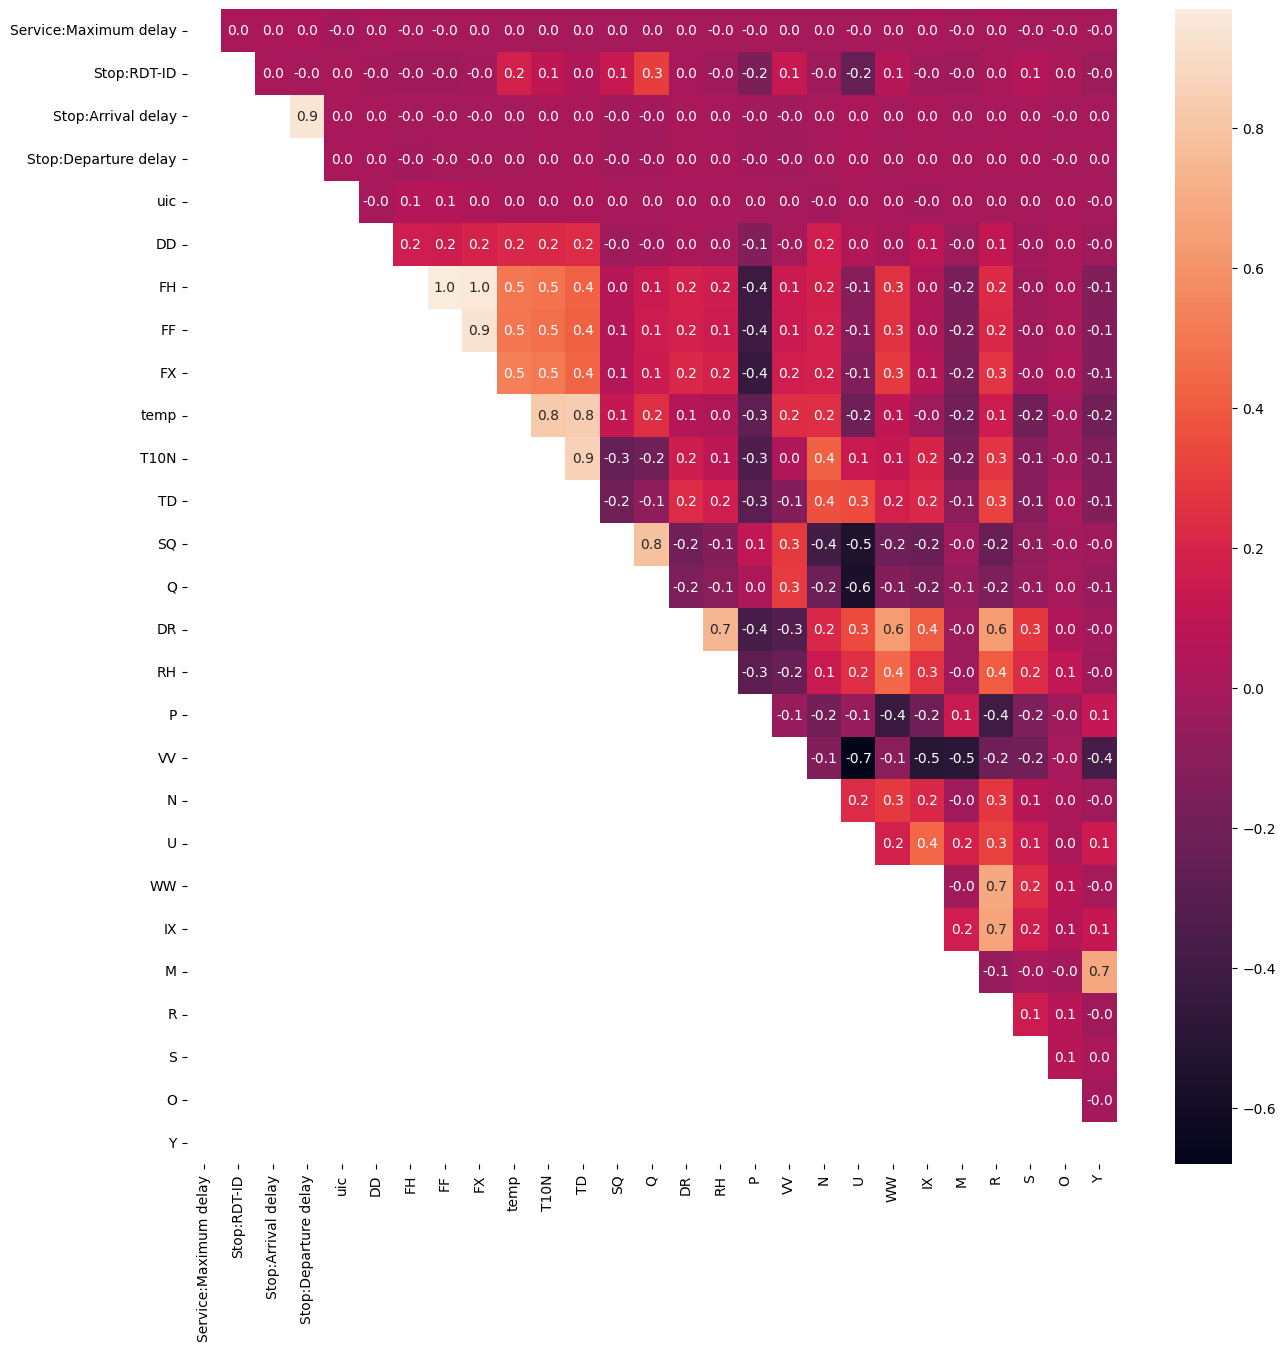

In [45]:
plt.subplots(figsize=(15, 15))
corr = Test_combined_df.select_dtypes(include=['int32', 'int64', 'float64']).corr()
mask = np.tril(corr)
sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f")

Uit de correlatieplot is al redelijk wat zichtbaar, maar ik ga ook even naar de pairplot kijken om te zien of er nog meer duidelijkheid naar voren komt.

In [48]:
plt.figure(figsize=(40,40))
sns.pairplot(Test_combined_df[['Service:Type','Stop:Arrival time', 'Stop:Departure time', 'Stop:Departure delay', 
                               'Stop:Arrival delay', 'temp', 'WW', 'IX', 'M', 'R', 'S', 'O', 'Y']], hue='Service:Type', corner= True, palette='rainbow', kind='kde')
plt.savefig('Combimed_Weather_Train_Pairplot.png')

KeyboardInterrupt: 